# Visualizations

## Packages, Presets and Loading the Data

In [1]:
# Standard Library Imports
from dataclasses import dataclass
from pathlib import Path
import re
from typing import Dict, List, Optional, Tuple

# Third-Party Imports
from IPython.display import display
import numpy as np
import pandas as pd
import plotnine as pn
from plotnine import (
    aes,
    element_text,
    geom_line,
    geom_vline,
    ggplot,
    labs,
    scale_color_manual,
    scale_x_continuous,
    scale_y_continuous,
    theme,
)
import seaborn as sns


# Color palettes for visualization (inspired by JAMA, and extended with some more colors)
PALETTE = [
    "#374E55FF",  # Dark Slate Gray
    "#8F44FFFF",  # Purple
    "#00A1D5FF",  # Blue
    "#B24745FF",  # Red
    "#79AF97FF",  # Sea Green
    "#6A6599FF",  # Purple
    "#80796BFF",  # Brown
    "#FFC107FF",  # Mustard Yellow
    "#00C49AFF",  # Teal
    "#FF7043FF",  # Coral
    "#003366FF",  # Navy Blue
    "#66BB6AFF",  # Mint Green
    "#BA68C8FF",  # Light Purple
    "#8B0000FF",  # Burgundy
    "#556B2FFF",  # Olive Green
    "#FFD700FF",  # Gold
    "#40E0D0FF",  # Turquoise
    "#E6E6FAFF",  # Lavender
    "#800000FF",  # Maroon
    "#A0522DFF",  # Sienna Brown
]

METRICS = ['eigenvalues', 'train_metrics', 'test_metrics', 'forgetting_metrics', 'overlaps']
ABLATION_TYPES = ['width', 'bs', 'lr']
SUBSPACE_TYPES = ['bulk', 'dominant', 'None']

ABLATION_PATTERN = r'../outputs/{}/width-(\d+)_bs-(\d+)_lr-(\d+\.?\d*)'
MAIN_PATTERN = r'../outputs/{}/subspace-{}'

@dataclass
class ExperimentDefaults:
    """Container for experiment default parameters."""
    width: int
    bs: int
    lr: float

THEME_ACADEMIC = pn.theme(
    text=pn.element_text(family="monospace"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=8),
    legend_title=pn.element_text(size=9),
    panel_background=pn.element_rect(fill="white"),
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    legend_position="right",
    legend_key_size=8,
    plot_margin=0.02,
    figure_size=(8, 4),
)

def add_step(eigenvalues: pd.DataFrame) -> pd.DataFrame:
    """Add step numbers to eigenvalue data based on eigenvalue_nr."""
    k = eigenvalues["eigenvalue_nr"].max()
    eigenvalues = eigenvalues.copy()
    eigenvalues['step'] = (eigenvalues.index // k)
    return eigenvalues

def parse_experiment_params(folder_name: str, experiment_pattern: re.Pattern) -> Tuple[int, int, float]:
    """Extract width, batch size, and learning rate from experiment folder name."""
    match = experiment_pattern.match(folder_name)

    return int(match.group(1)), int(match.group(2)), float(match.group(3))

def load_main_results(experiment_name: str, defaults: ExperimentDefaults) -> Dict:
    """Load and process main experiment results from CSV files."""
    main_dict = {key: {subkey: {} for subkey in METRICS} for key in SUBSPACE_TYPES}
    
    for space in SUBSPACE_TYPES:
        metric_dir = Path(MAIN_PATTERN.format(experiment_name, space) + '/metrics')
        
        if metric_dir.is_dir():
            for csv_file in metric_dir.glob('*.csv'):
                df = pd.read_csv(csv_file)
                metric_name = csv_file.stem
                
                # add some meta deta for easy facet wrapping
                df['width'], df['bs'], df['lr'] = defaults.width, defaults.bs, defaults.lr
                df['optimizer'] = space 
                df['experiment'] = experiment_name
                
                if metric_name == 'eigenvalues':
                    df = add_step(df)
                elif metric_name == 'train_metrics':
                    df = df.reset_index() # we need training_step (index) as variable for plotting
                    df.rename(columns={'index': 'training_step'}, inplace=True) # rename index to "training_step"
                    
                main_dict[space][metric_name] = df
                
    return main_dict

def load_ablation_results(experiment_name: str, defaults: ExperimentDefaults) -> Dict:
    """Load and process ablation study results from CSV files."""
    ablation_dict = {key: {subkey: {} for subkey in METRICS} for key in ABLATION_TYPES}
    experiment_pattern = re.compile(ABLATION_PATTERN.format(f'{experiment_name}_ablation'))

    ablation_path = Path('../outputs/'+f'{experiment_name}_ablation')
        
    for item in ablation_path.iterdir():
        if item.is_dir():
            width, bs, lr = parse_experiment_params(str(item), experiment_pattern)
            metric_dir = item / "metrics"
            
            if metric_dir.is_dir():
                for csv_file in metric_dir.glob('*.csv'):
                    df = pd.read_csv(csv_file)
                    metric_name = csv_file.stem

                    # Add meta data for easy facet wrapping
                    df['width'], df['bs'], df['lr'] = width, bs, lr
                    df['experiment'] = experiment_name
                    df['optimizer'] = 'bulk' # all ablation results are done with SGD-BULK
                    
                    if metric_name == 'eigenvalues':
                        df = add_step(df)
                    elif metric_name == 'train_metrics':
                        df = df.reset_index()
                        df.rename(columns={'index': 'training_step'}, inplace=True)
                        
                    if (width == defaults.width and bs == defaults.bs and lr != defaults.lr):
                        ablation_dict['lr'][metric_name][lr] = df
                    elif (width != defaults.width and bs == defaults.bs and lr == defaults.lr):
                        ablation_dict['width'][metric_name][width] = df
                    elif (width == defaults.width and bs != defaults.bs and lr == defaults.lr):
                        ablation_dict['bs'][metric_name][bs] = df
    
    return ablation_dict

def get_task_boundaries(main_dict: Dict, space: str = 'bulk') -> np.ndarray:
    """Calculate indices where tasks change based on eigenvalues data."""
    temp = main_dict[space]['eigenvalues']
    return temp["step"].iloc[np.where(np.diff(temp['task_id']) != 0)[0]].values


# Default experimental configurations
PMNIST_DEFAULTS = ExperimentDefaults(width=100, bs=128, lr=0.01)
CIFAR10_DEFAULTS = ExperimentDefaults(width=32, bs=128, lr=0.001)
CIFAR100_DEFAULTS = ExperimentDefaults(width=32, bs=128, lr=0.001)

# Load results for each dataset
pmnist_ablation_dict = load_ablation_results('permuted_mnist', PMNIST_DEFAULTS)
pmnist_main_dict = load_main_results('permuted_mnist', PMNIST_DEFAULTS)

cifar10_ablation_dict = load_ablation_results('split_cifar10', CIFAR10_DEFAULTS)
cifar10_main_dict = load_main_results('split_cifar10', CIFAR10_DEFAULTS)

cifar100_ablation_dict = load_ablation_results('split_cifar100', CIFAR100_DEFAULTS)
cifar100_main_dict = load_main_results('split_cifar100', CIFAR100_DEFAULTS)

# Calculate task boundaries
PMNIST_BOUNDARIES = get_task_boundaries(pmnist_main_dict)
CIFAR10_BOUNDARIES = get_task_boundaries(cifar10_main_dict)
CIFAR100_BOUNDARIES = get_task_boundaries(cifar100_main_dict)

## Results

In [2]:
def plot_topk_next_topk_eigenvalues(
    eigenvalues: pd.DataFrame,
    k: int,
    boundaries: List[float],
    facet: Optional = None
) -> pn.ggplot:
    """Plot top k and next top k eigenvalues over training steps."""
    
    # Create a copy to avoid modifying the input DataFrame
    temp = eigenvalues.copy()
    
    # Assign "Next Top-k" as the default group
    temp["group"] = f"Next Top-{k}"

    # Assign "Top-k" group based on eigenvalue number
    temp.loc[temp["eigenvalue_nr"] <= k, "group"] = f"Top-{k}"
    
    # Create a new column for color mapping
    temp["color_group"] = temp.apply(
        lambda row: f"Top {row['eigenvalue_nr']}" if row["group"] == f"Top-{k}" else f"Next Top-{k}",
        axis=1
    )
    
    # Define legend order: Top 1, Top 2, ..., Top k, Next Top-k
    topk_labels = [f"Top {i}" for i in range(1, k+1)]
    desired_order = topk_labels + [f"Next Top-{k}"]
    
    # Set 'color_group' as a categorical type with the desired order
    temp["color_group"] = pd.Categorical(
        temp["color_group"],
        categories=desired_order,
        ordered=True
    )
    
    # Generate the "Paired" palette for Top-k eigenvalues
    paired_palette = sns.color_palette(PALETTE).as_hex()
    
    # Create a color mapping dictionary
    color_mapping = {f"Top {i}": paired_palette[i-1] for i in range(1, k+1)}
    color_mapping[f"Next Top-{k}"] = "grey"  # Assign grey to Next Top-k
    
    # Define and create the plot
    fig = (
        ggplot(temp, aes(x="step", y="value", color="color_group", group="color_group"))
        + geom_line(size=0.75, alpha=0.8)
        + scale_color_manual(values=color_mapping)
        + labs(
            x="Training Step",
            y="Eigenvalue",
            color="Eigenvalue"
        )
        + THEME_ACADEMIC
        + geom_vline(
            xintercept=boundaries,
            color="red",
            linetype="dashed",
            size=0.3
        )
    )
    
    return fig


def topk_overlap(
    overlap: pd.DataFrame,
    boundaries: List[float],
    ablation: Optional = None
) -> pn.ggplot:
    """Plot the overlap of top k in a specified space over training steps."""
    
    id_vars = ["task_id", "step", "optimizer"]

    if ablation:
        id_vars.append(ablation)

    overlap_long = pd.melt(
        overlap,
        id_vars=id_vars,
        value_vars=[f"overlap_dominant"],
        var_name="metric",
        value_name="value",
    )
        
    # Create the plot with lines for each task_id
    fig = (
        pn.ggplot(
            overlap_long,
            pn.aes(x="step", y="value", color="factor(task_id)", group="task_id"),
        )
        + pn.geom_line(alpha=0.8, size=0.75)
        + pn.scale_color_manual(values=PALETTE, name="Task ID")
        + pn.geom_vline(
            xintercept=boundaries, color="red", linetype="dashed", size=0.3, alpha=0.5
        )
        + pn.scale_y_continuous(
            limits=[0, 1.01],
            breaks=np.arange(0, 1.1, 0.2),
        )
        + THEME_ACADEMIC
        + pn.labs(
            x="Training Step t1-t2",
            y="Overlap",
        )
    )
    
    # Add facet wrapping if ablation is specified
    if ablation:
        fig += pn.facet_wrap(f"~{ablation}")
    
    return fig


def plot_max_eigenvalues_dom_bulk_plain(
    eigenvalues: pd.DataFrame
) -> pn.ggplot:
    """Plot the first eigenvalue over training steps for different SGD configurations."""

    optimizer_mapping = {
        "None": "Plain SGD",
        "bulk": "SGD-BULK",
        "dominant": "SGD-DOM"
    }
    
    # Create a copy to avoid modifying the input DataFrame and map 'space' values
    temp = eigenvalues.copy()
    temp["optimizer"] = temp["optimizer"].map(optimizer_mapping)
    
    # Filter to include only the first eigenvalue
    filtered_temp = temp[temp['eigenvalue_nr'] == 1]
    
    # Create the plot with step vs value
    fig = (
        pn.ggplot(
            filtered_temp,
            pn.aes(
                x="step",
                y="value",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.8, color="#79AF97FF")  # Plot eigenvalue line
        + THEME_ACADEMIC  # Apply predefined academic theme
        + pn.facet_grid("~optimizer")  # Facet by 'space' with free x scales
        + pn.theme(legend_position="none")  # Hide the legend
        + pn.labs(
            x="Training Step",
            y="Eigenvalue",
        )
    )
    
    return fig


def plot_train_metric(
    train_metric: pd.DataFrame,
    boundaries: List[float]
) -> pn.ggplot:
    """Plot training loss over steps, colored by optimizer with boundary lines."""
    
    # Create a filter to exclude bulk and dominant spaces for task_id 0
    fil = (
        ((train_metric['optimizer'] == 'bulk') | (train_metric['optimizer'] == 'dominant')) 
        & (train_metric['task_id'] == 0)
    )
    
    # Mapping from 'space' values to descriptive optimizer labels
    optimizer_mapping = {
        "None": "Plain SGD",
        "bulk": "SGD-BULK",
        "dominant": "SGD-DOM"
    }
    
    # Create a copy to avoid modifying the input DataFrame and map 'space' values
    temp = train_metric.copy()
    temp["optimizer"] = temp["optimizer"].map(optimizer_mapping)

    # Define the plot with training_step vs loss, colored by optimizer
    fig = (
        pn.ggplot(
            temp[~fil],  # Filter out specified rows
            pn.aes(
                x="training_step",
                y="loss",
                color="factor(optimizer)",
                group="optimizer",
            ),
        )
        + pn.geom_line(size=0.75, alpha=0.8)  # Add lines for each optimizer
        + pn.scale_color_manual(values=PALETTE, name="Optimizer")  # Apply custom color palette
        + pn.geom_vline(
            xintercept=boundaries, 
            color="red", 
            linetype="dashed", 
            size=0.3  # Add vertical dashed lines at boundary steps
        )
        + THEME_ACADEMIC  # Apply predefined academic theme
        + pn.labs(
            x="Training Step",
            y="Cross Entropy Loss",
        ) 
    )

    return fig


def plot_test_metric(
    test_metric: pd.DataFrame
) -> pn.ggplot:
    """Plot accuracy over evaluated tasks, colored by task ID and faceted by optimizer."""
    
    optimizer_mapping = {
        "None": "Plain SGD",
        "bulk": "SGD-BULK",
        "dominant": "SGD-DOM"
    }
    
    # Create a copy to avoid modifying the input DataFrame and map 'space' values
    temp = test_metric.copy()
    temp["optimizer"] = temp["optimizer"].map(optimizer_mapping)
    
    # Define the plot with evaluated_at_task vs accuracy, colored by task_id
    fig = (
        pn.ggplot(
            temp,
            pn.aes(
                x="evaluated_at_task",
                y="accuracy",
                color="factor(task_id)",
                group="task_id",
            ),
        )
        + pn.scale_x_continuous(
            breaks=range(temp['task_id'].max() + 1),  # Set integer breaks on x-axis
            labels=range(temp['task_id'].max() + 1)   # Set integer labels on x-axis
        )
        + pn.geom_line(size=0.75, alpha=0.8)  # Add lines for each task_id
        + pn.geom_point(size=0.8)             # Add points for each data point
        + pn.scale_color_manual(values=PALETTE)  # Apply custom color palette
        + pn.facet_wrap("~optimizer")            # Facet the plot by optimizer type
        + THEME_ACADEMIC                       # Apply predefined academic theme
        + pn.labs(
            x="Evaluated at Task",
            y="Accuracy (in percent)",
            color="Task"
        )
    )
    
    return fig


def eigenvalues_ablation(
    eigenvalues_main: pd.DataFrame,
    eigenvalues_ablation: Dict,
    boundaries: List[float]
) -> None:
    """Generate and display eigenvalue plots for each ablation type over training steps."""
    
    # Filter the main eigenvalues DataFrame to include eigenvalues numbered 1 through 10
    evs = eigenvalues_main[eigenvalues_main['eigenvalue_nr'].between(1, 10)].copy()

    # Iterate over each ablation type defined in ABLATION_TYPES
    for ab in ABLATION_TYPES:
        # Concatenate all eigenvalue DataFrames for the current ablation type
        temp = pd.concat(eigenvalues_ablation[ab]['eigenvalues'].values(), ignore_index=True)
        # Combine with the filtered main eigenvalues DataFrame
        temp = pd.concat([temp, evs], ignore_index=True)
        
        # Define the plot with step vs eigenvalue, colored by eigenvalue number
        fig = (
            pn.ggplot(
                temp,
                pn.aes(
                    x="step",
                    y="value",
                    color="factor(eigenvalue_nr)",
                    group="eigenvalue_nr",
                ),
            )
            + pn.geom_line(size=0.75, alpha=0.8)  # Add semi-transparent lines for each eigenvalue
            + pn.scale_color_manual(values=PALETTE)  # Apply custom color palette
            + pn.geom_vline(
                xintercept=boundaries, color="red", linetype="dashed", size=0.3
            )  # Add vertical dashed lines at boundary steps
            + pn.facet_wrap(f"~{ab}")  # Facet the plot by the current ablation type
            + THEME_ACADEMIC  # Apply predefined academic theme
            + pn.theme(legend_position="none")  # Hide the legend
            + pn.labs(
                x="Training Step",
                y="Eigenvalue",
            )  # Set axis labels
        )
        
        # Apply a symmetric logarithmic transformation to the y-axis for 'lr' ablation type
        if ab == 'lr':
            fig += pn.scale_y_continuous(trans='symlog')
        
        # Display the generated plot
        display(fig)


def overlap_ablation(
    overlap_main: pd.DataFrame,
    overlap_ablation: Dict,
    boundaries: List[float]
) -> None:
    """Generate and display overlap plots for each ablation type."""
    
    # Iterate over each ablation type defined in ABLATION_TYPES
    for ab in ABLATION_TYPES:

        # Concatenate all overlap DataFrames for the current ablation type
        temp = pd.concat(overlap_ablation[ab]['overlaps'].values(), ignore_index=True)

        # Combine with the main overlap DataFrame
        temp = pd.concat([temp, overlap_main], ignore_index=True)
        
        # Generate the overlap plot using the topk_overlap function
        fig = topk_overlap(temp, boundaries, ab)
        
        # Clean up the temporary DataFrame to free memory
        del temp
        
        # Display the generated plot
        display(fig)

### Top-K versus next Top-K Eigenvalues for SGD

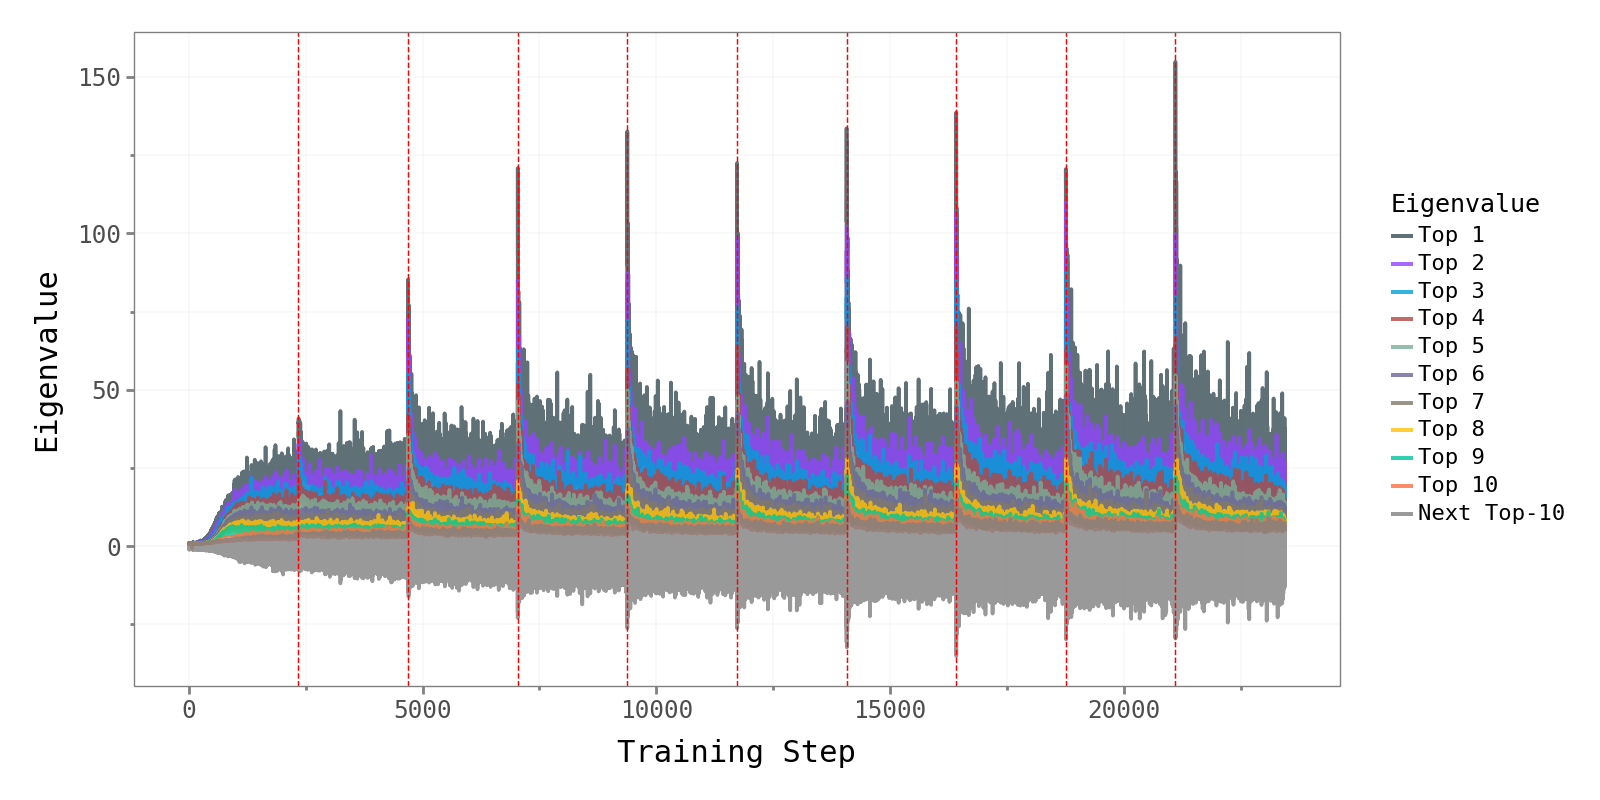

In [3]:
plot_topk_next_topk_eigenvalues(pmnist_main_dict['None']['eigenvalues'], 10, PMNIST_BOUNDARIES)

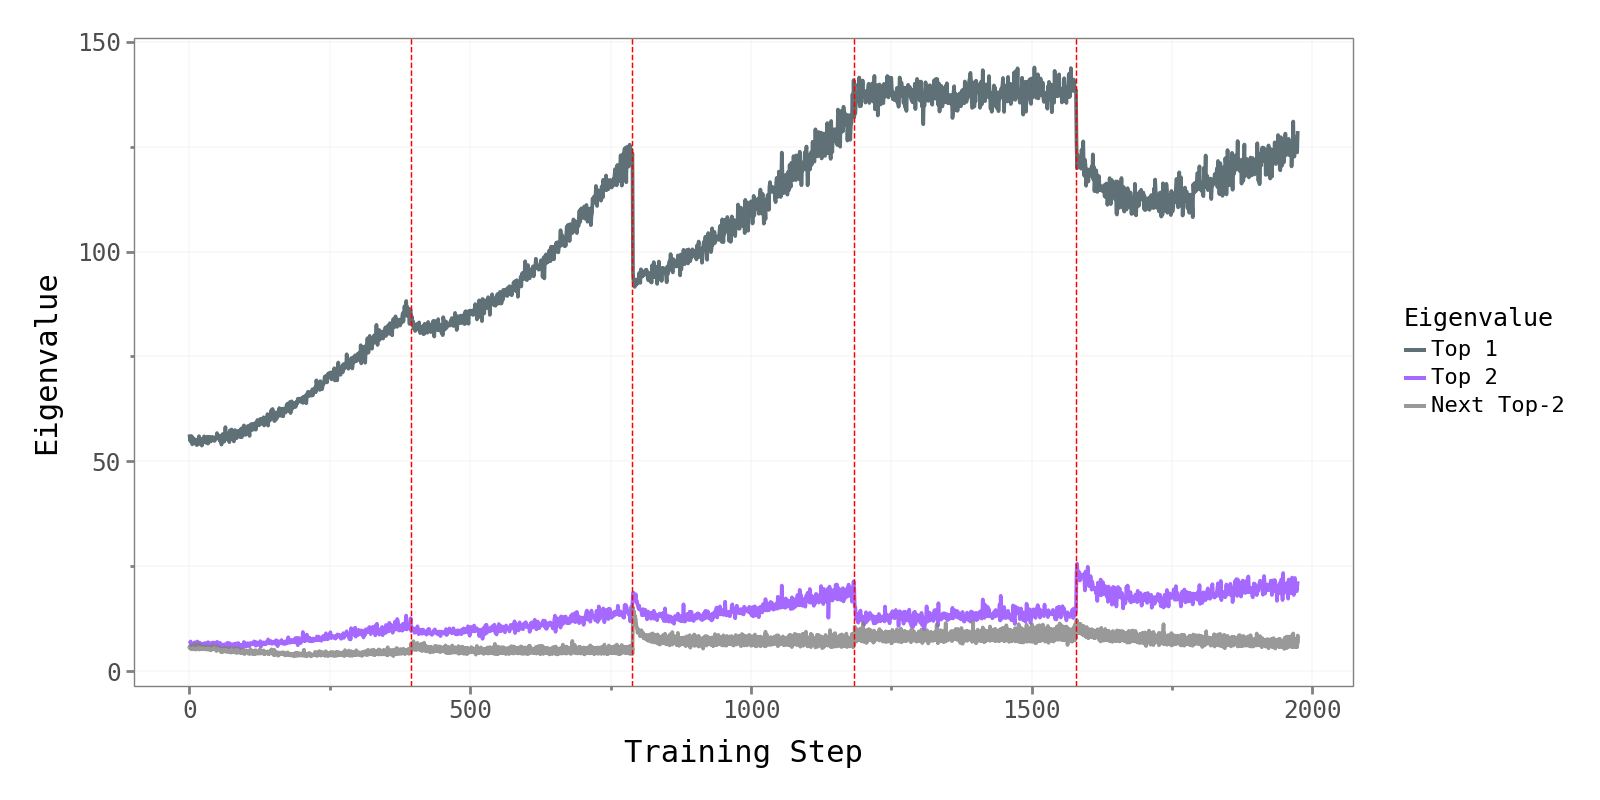

In [4]:
plot_topk_next_topk_eigenvalues(cifar10_main_dict['None']['eigenvalues'], 2, CIFAR10_BOUNDARIES)

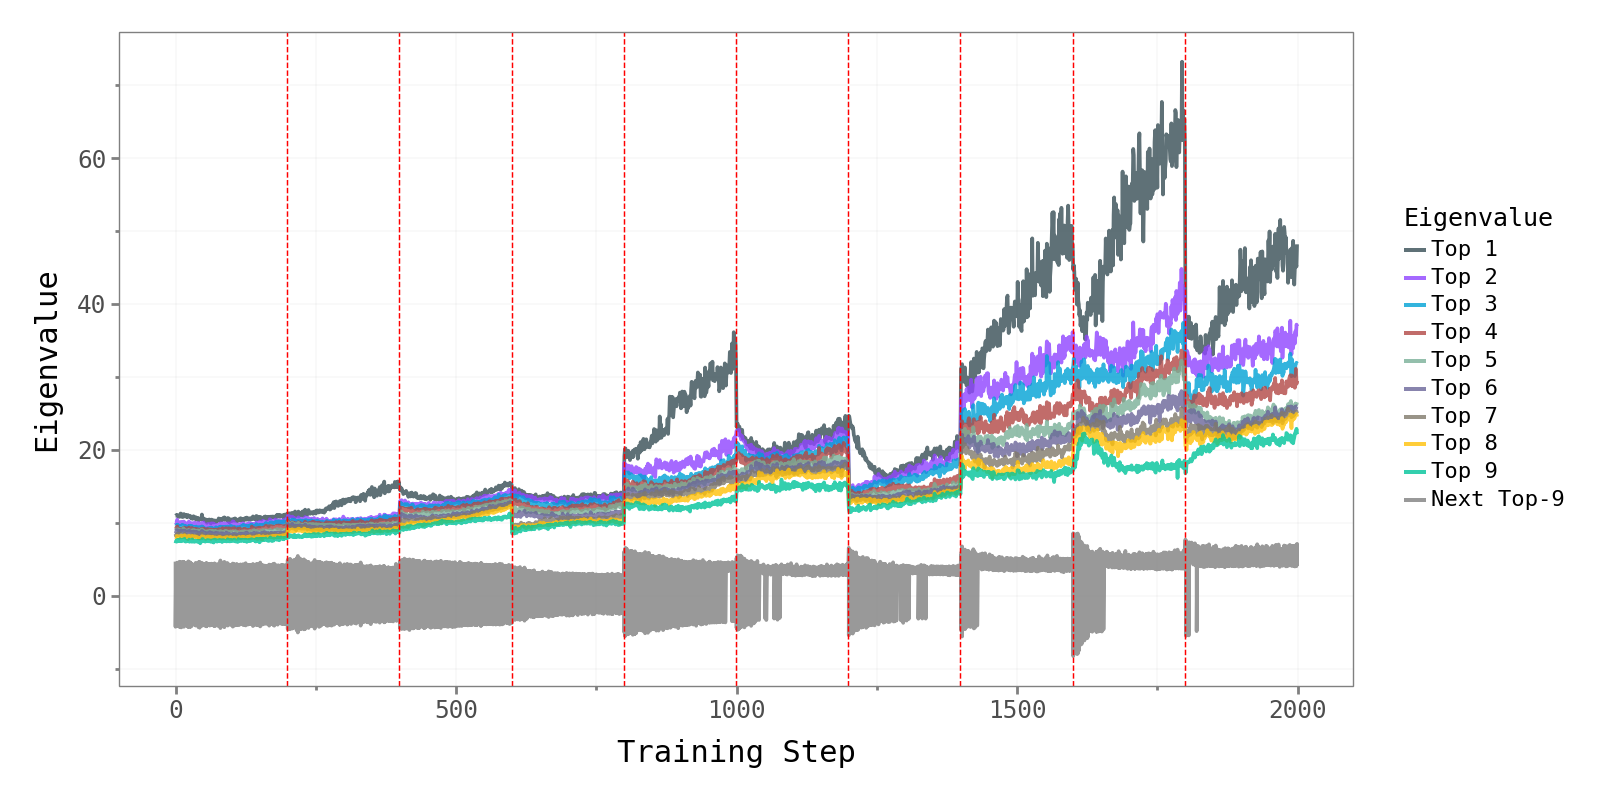

In [5]:
plot_topk_next_topk_eigenvalues(cifar100_main_dict['None']['eigenvalues'], 9, CIFAR100_BOUNDARIES)

### Top-K Overlap for SGD

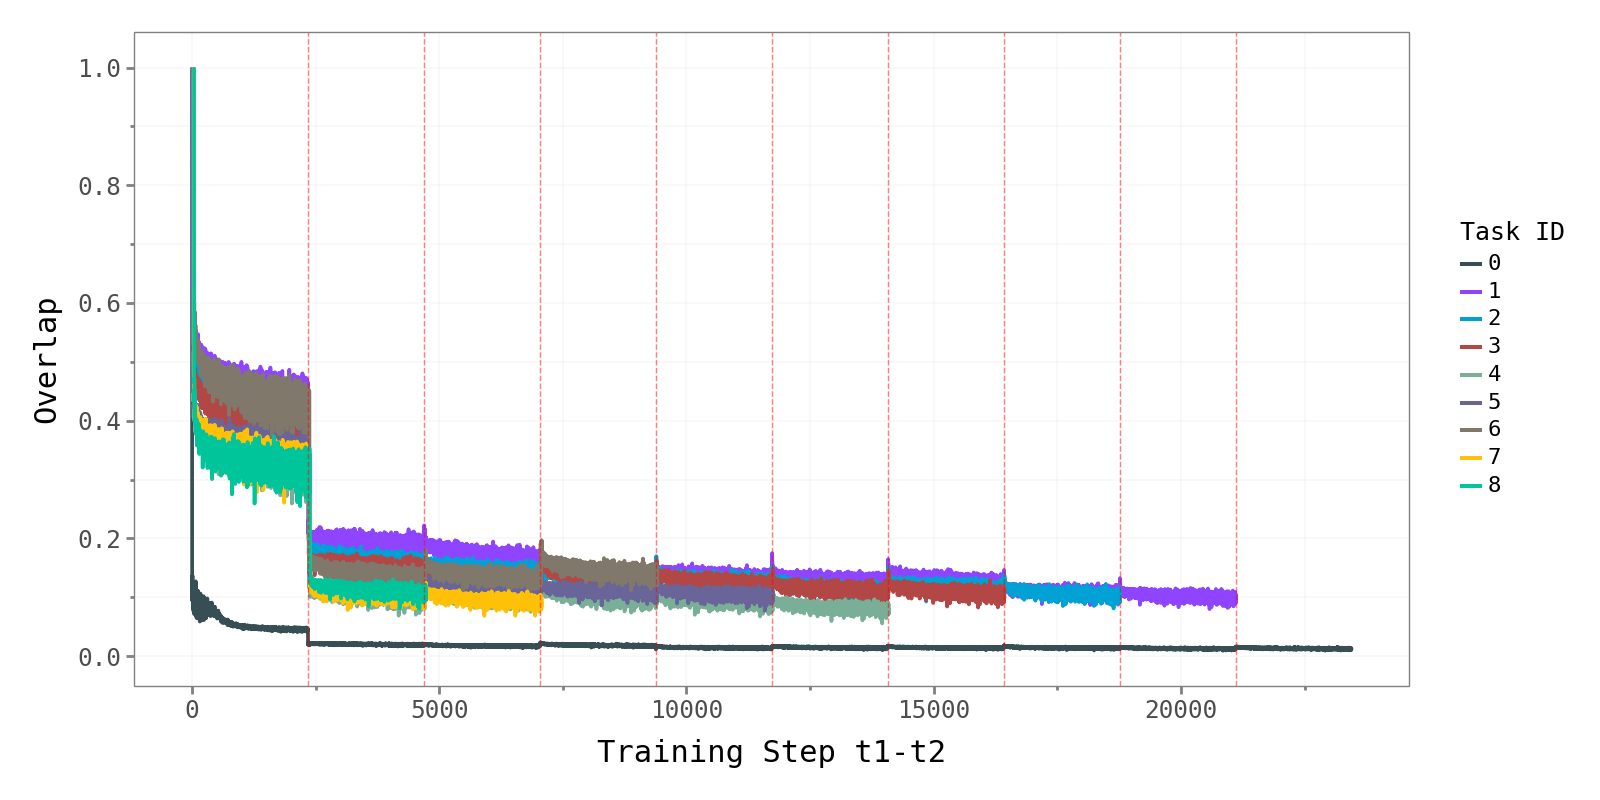

In [6]:
topk_overlap(pmnist_main_dict['None']['overlaps'], PMNIST_BOUNDARIES)

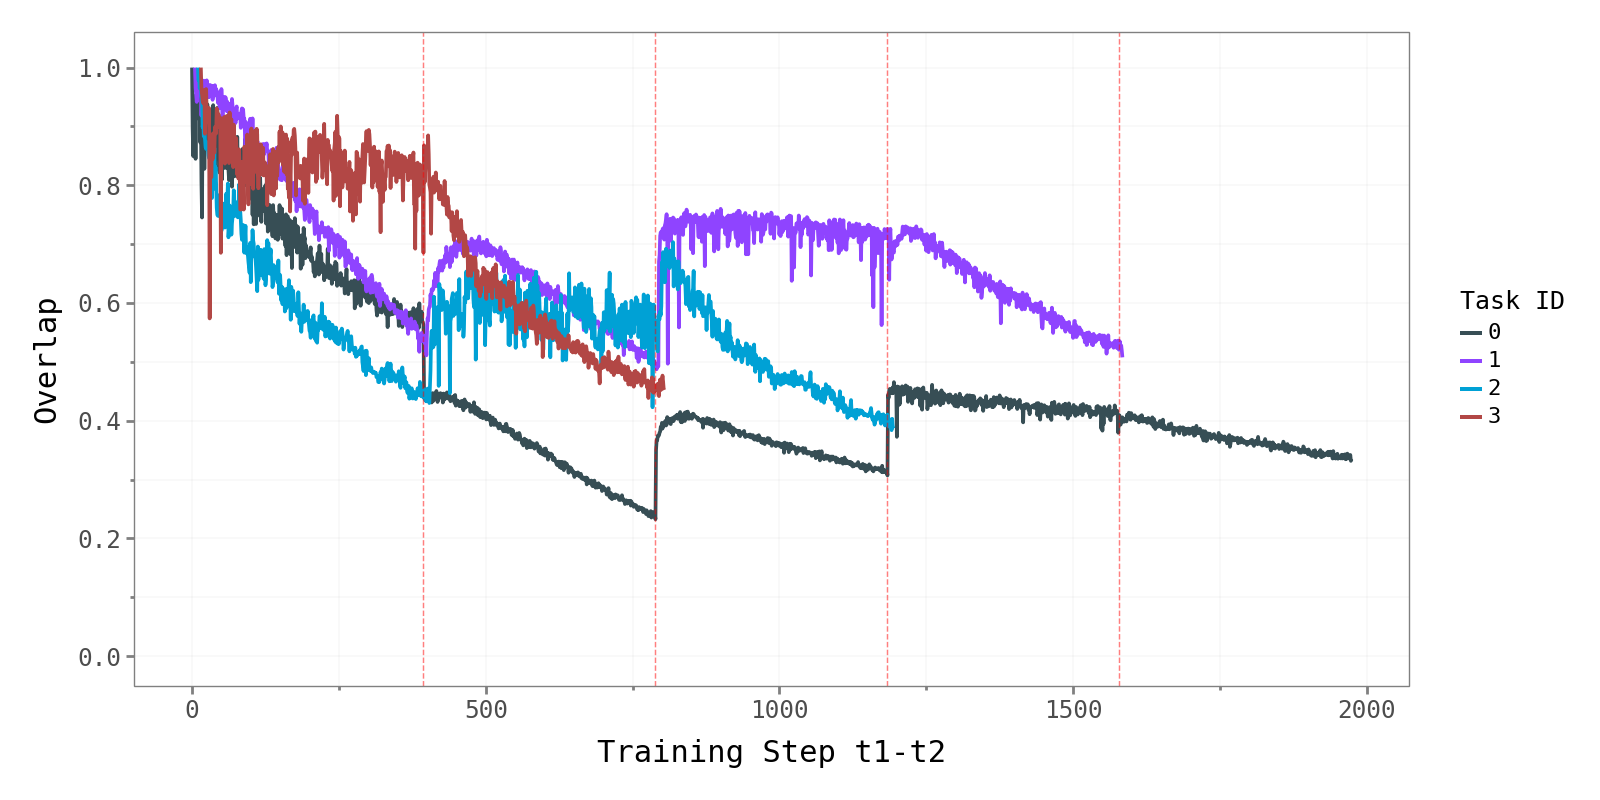

In [7]:
topk_overlap(cifar10_main_dict['None']['overlaps'], CIFAR10_BOUNDARIES)

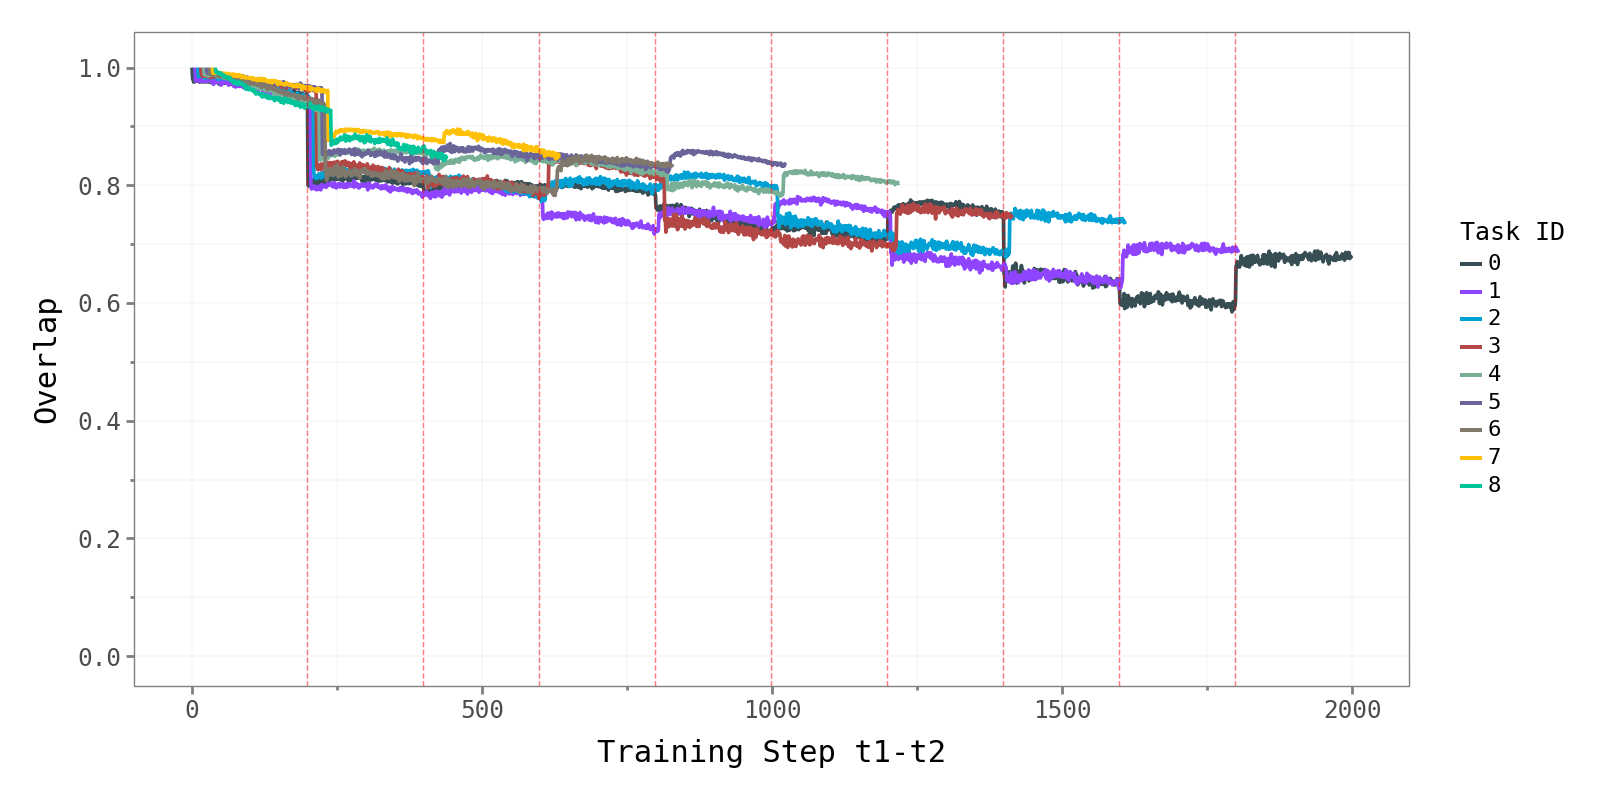

In [8]:
topk_overlap(cifar100_main_dict['None']['overlaps'], CIFAR100_BOUNDARIES)

### Max Eigenvalue over Time for SGD versus SGD-DOM versus SGD-BULK

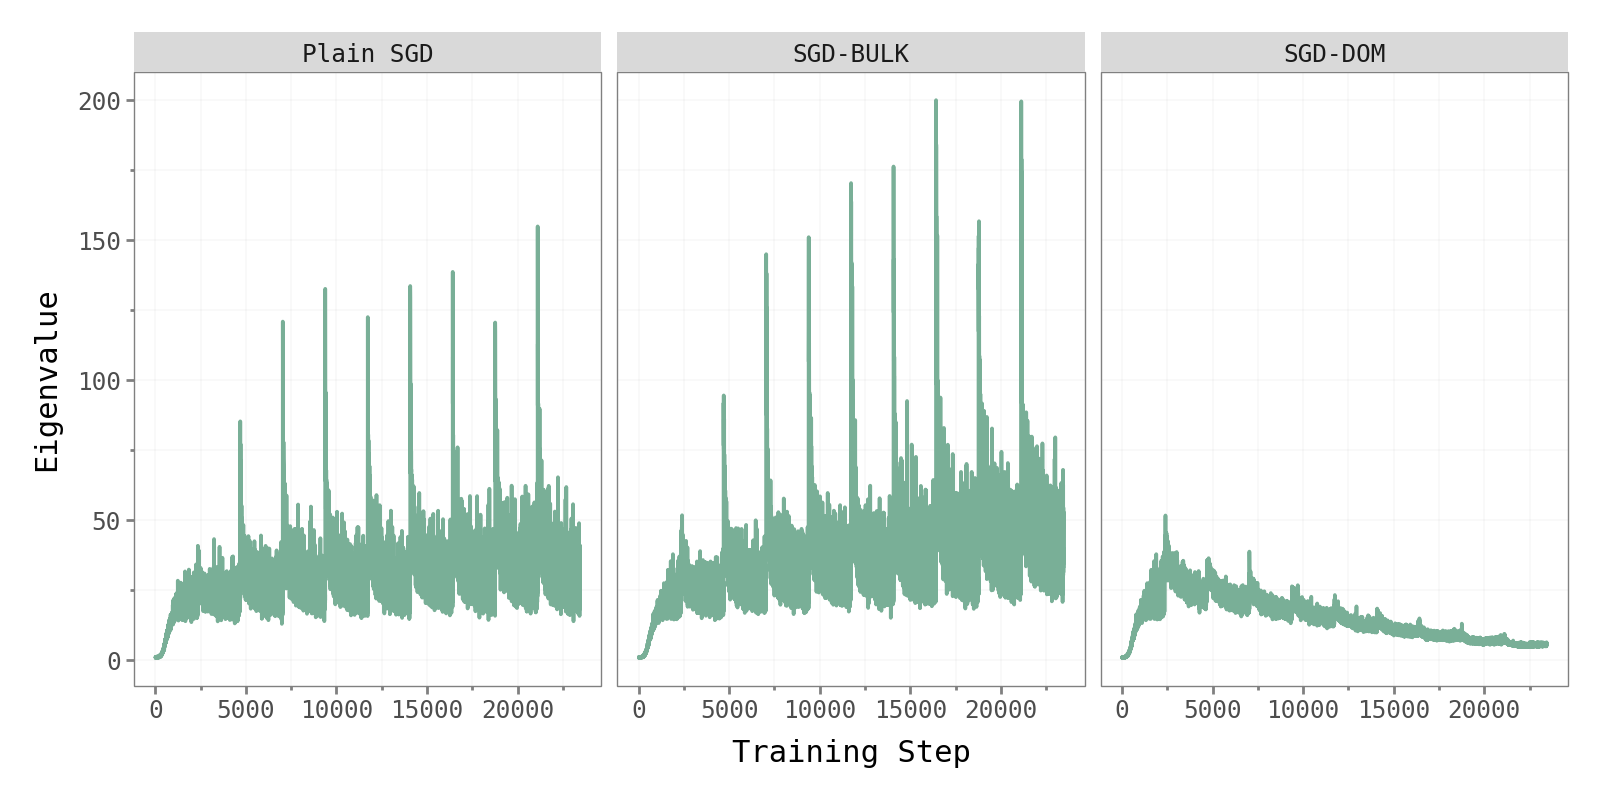

In [9]:
plot_max_eigenvalues_dom_bulk_plain(eigenvalues = pd.concat([pmnist_main_dict[space]['eigenvalues'] for space in SUBSPACE_TYPES]))

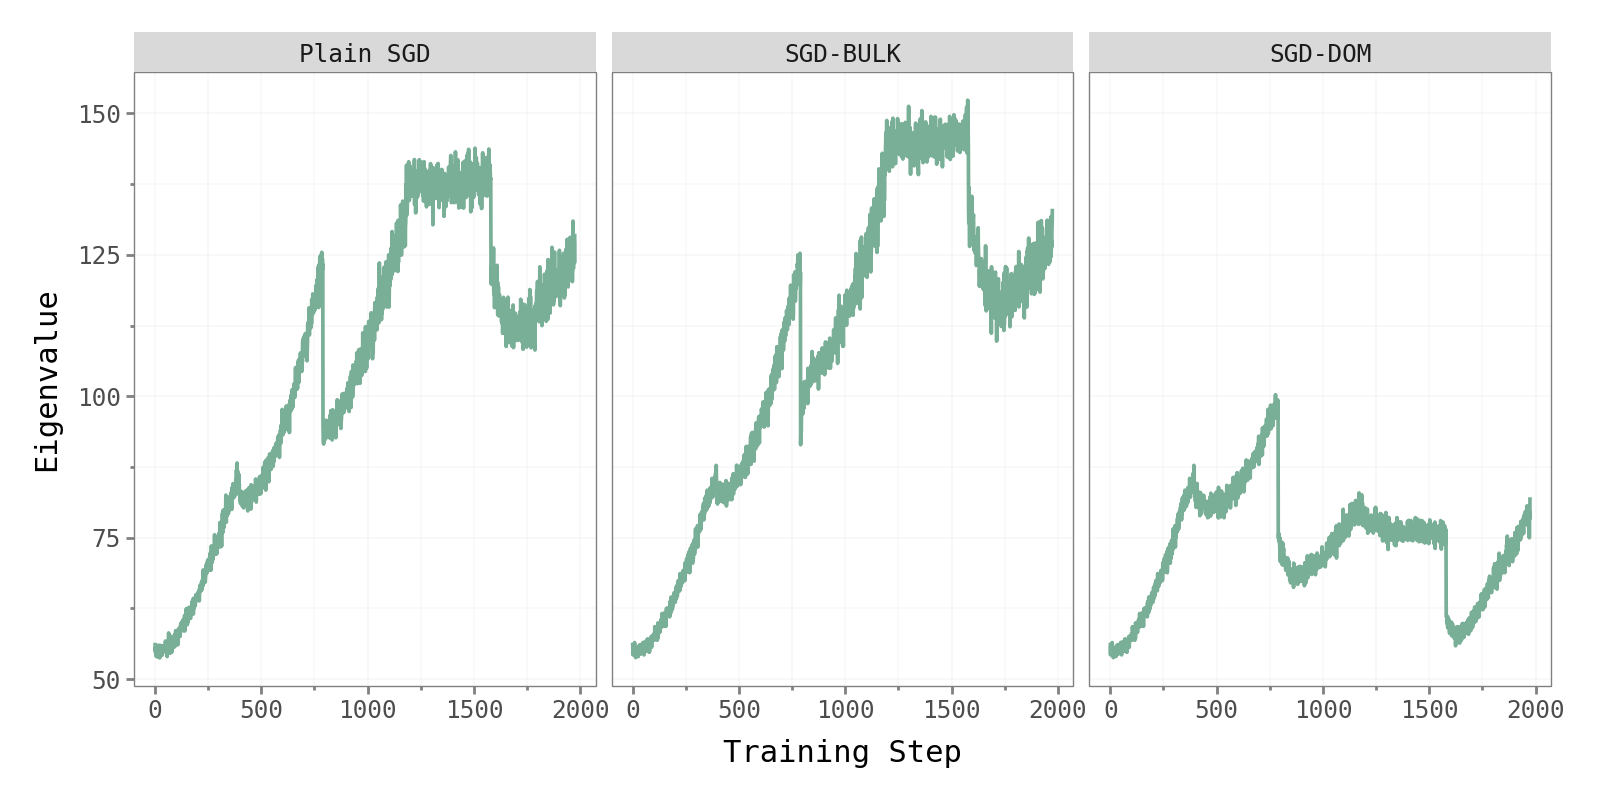

In [10]:
plot_max_eigenvalues_dom_bulk_plain(eigenvalues = pd.concat([cifar10_main_dict[space]['eigenvalues'] for space in SUBSPACE_TYPES]))

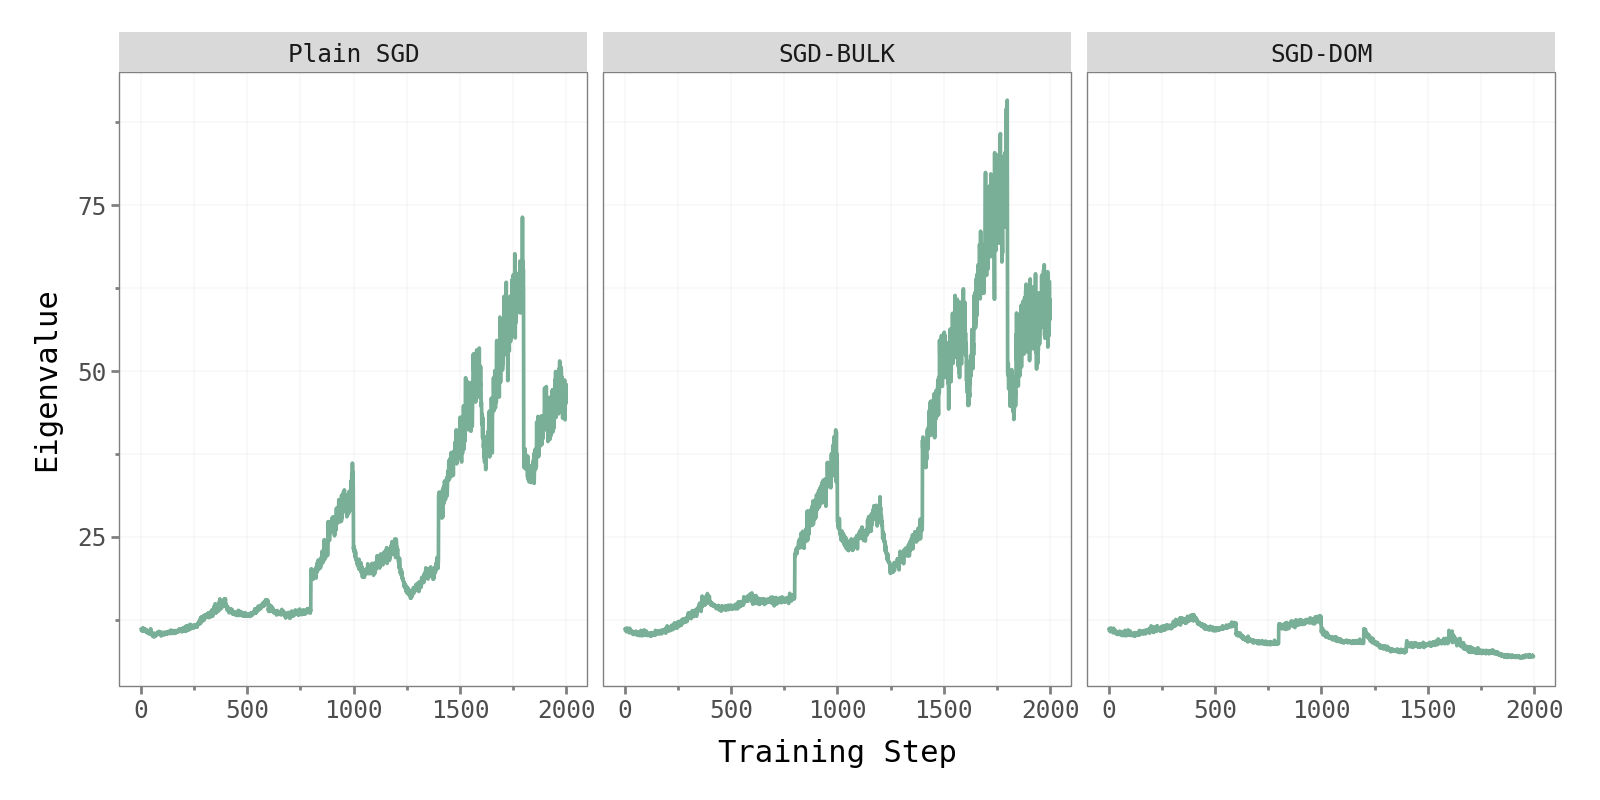

In [11]:
plot_max_eigenvalues_dom_bulk_plain(eigenvalues = pd.concat([cifar100_main_dict[space]['eigenvalues'] for space in SUBSPACE_TYPES]))

### Training Metrics over Time for SGD versus SGD-DOM versus SGD-BULK

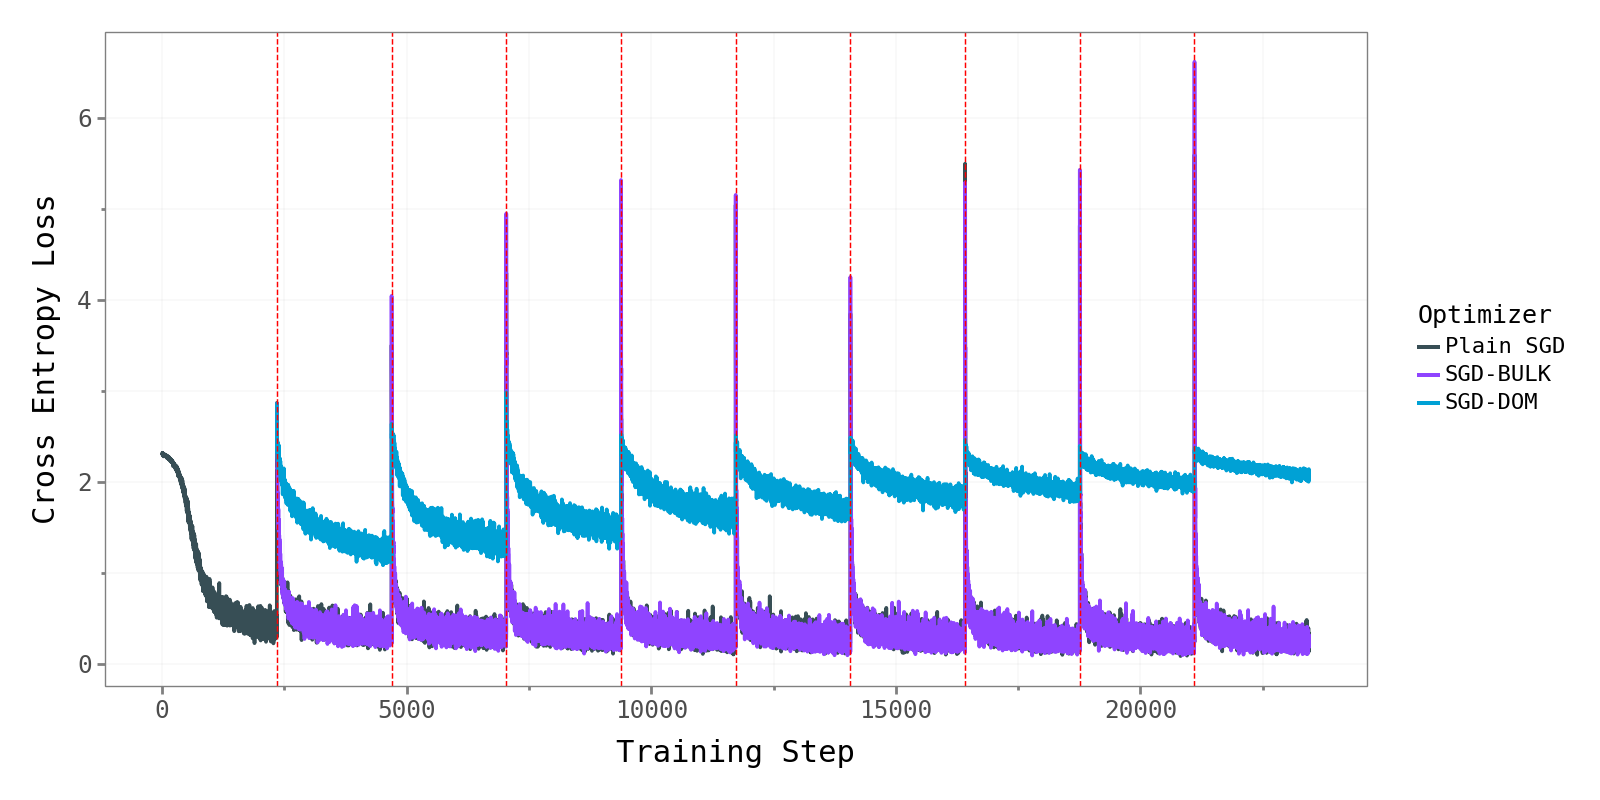

In [12]:
plot_train_metric(pd.concat([pmnist_main_dict[space]['train_metrics'] for space in SUBSPACE_TYPES]), PMNIST_BOUNDARIES)

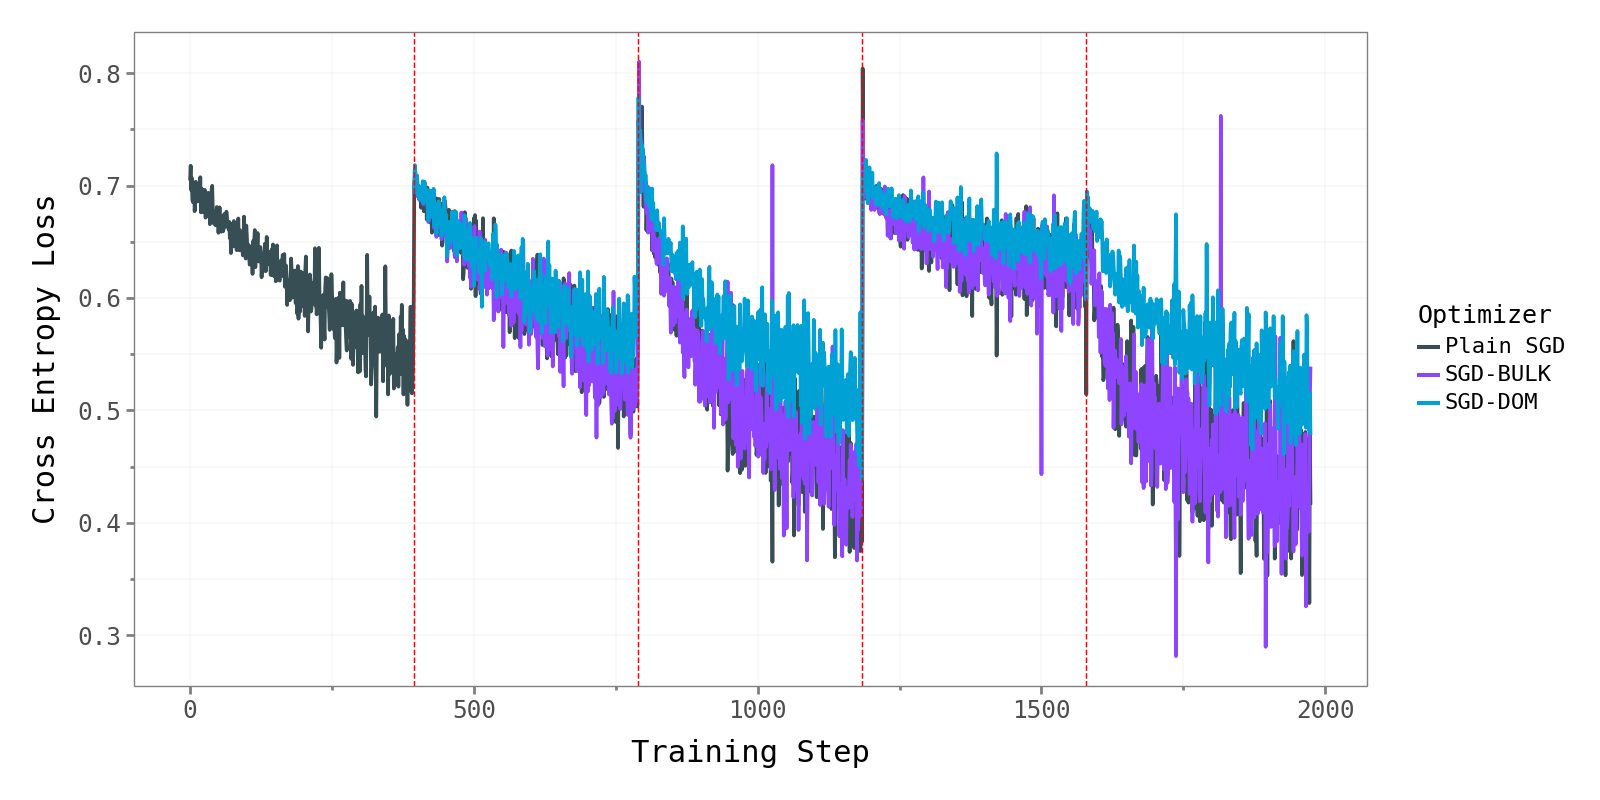

In [13]:
plot_train_metric(pd.concat([cifar10_main_dict[space]['train_metrics'] for space in SUBSPACE_TYPES]), CIFAR10_BOUNDARIES)

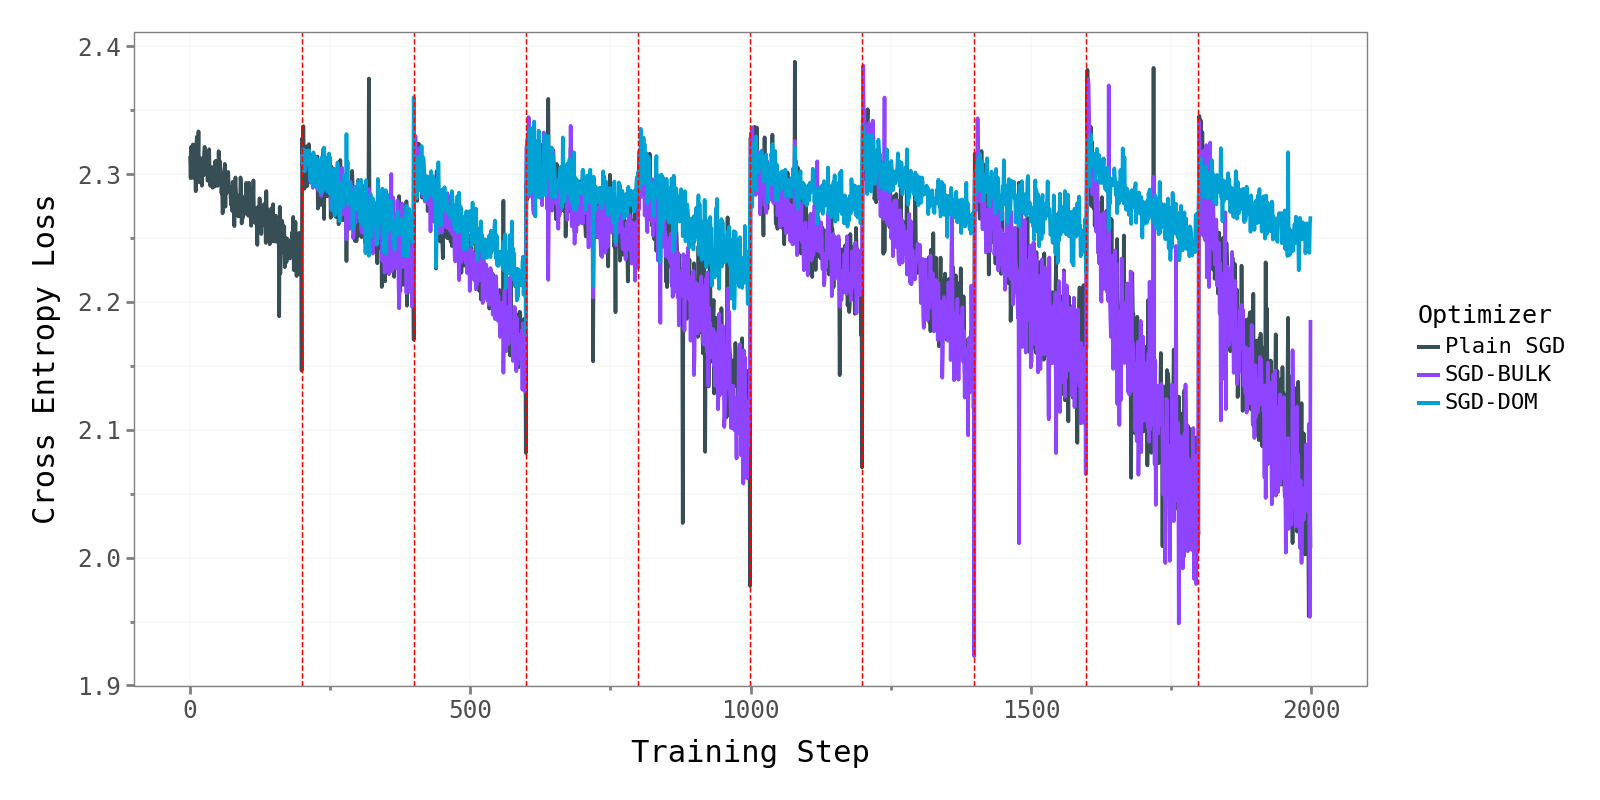

In [14]:
plot_train_metric(pd.concat([cifar100_main_dict[space]['train_metrics'] for space in SUBSPACE_TYPES]), CIFAR100_BOUNDARIES)

### Test Metrics over Time for SGD versus SGD-DOM versus SGD-BULK

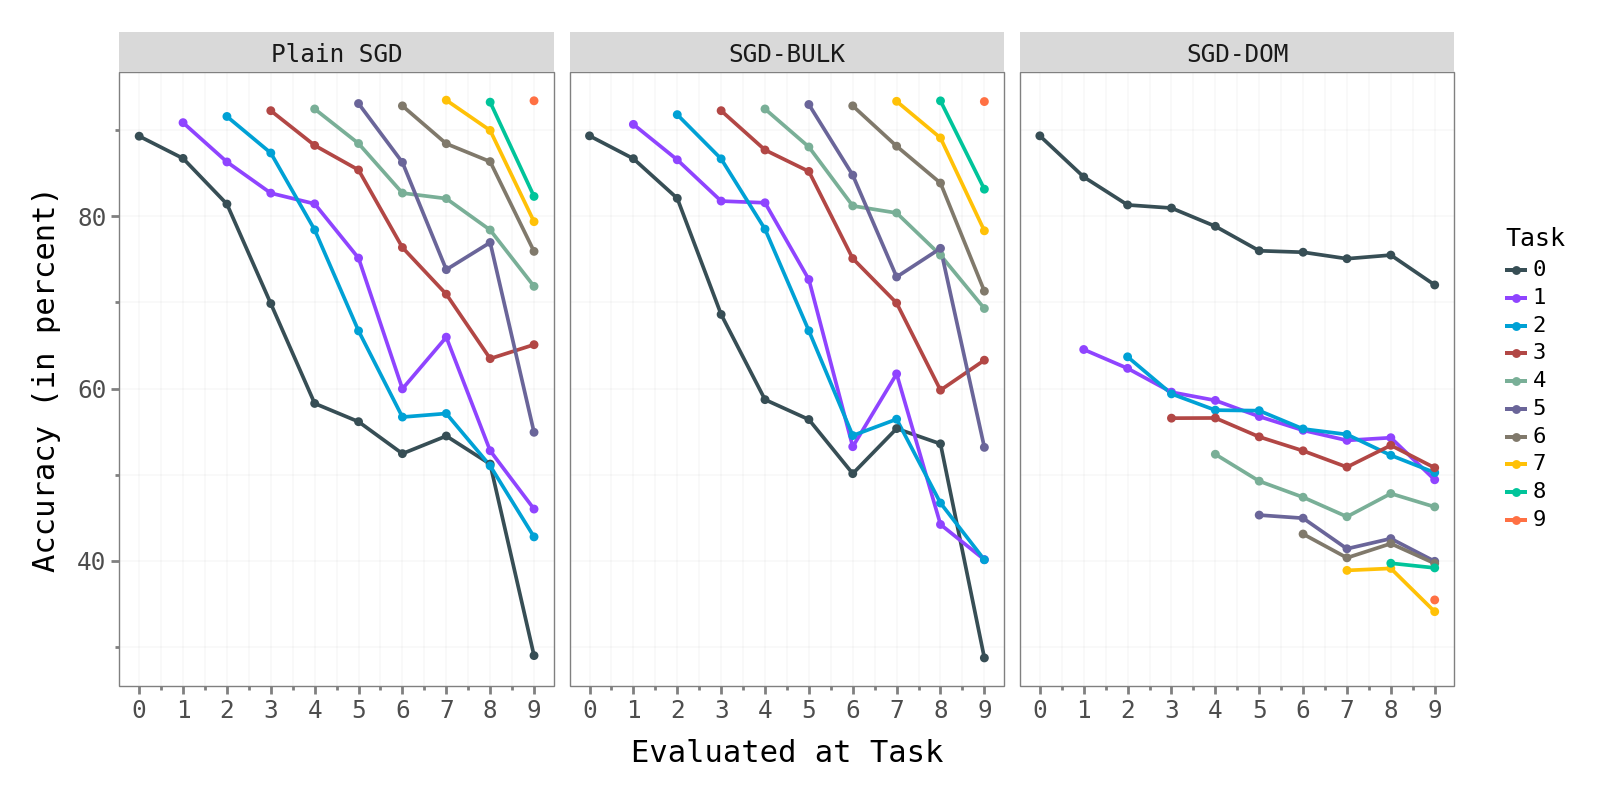

In [15]:
plot_test_metric(pd.concat([pmnist_main_dict[space]['test_metrics'] for space in SUBSPACE_TYPES]))

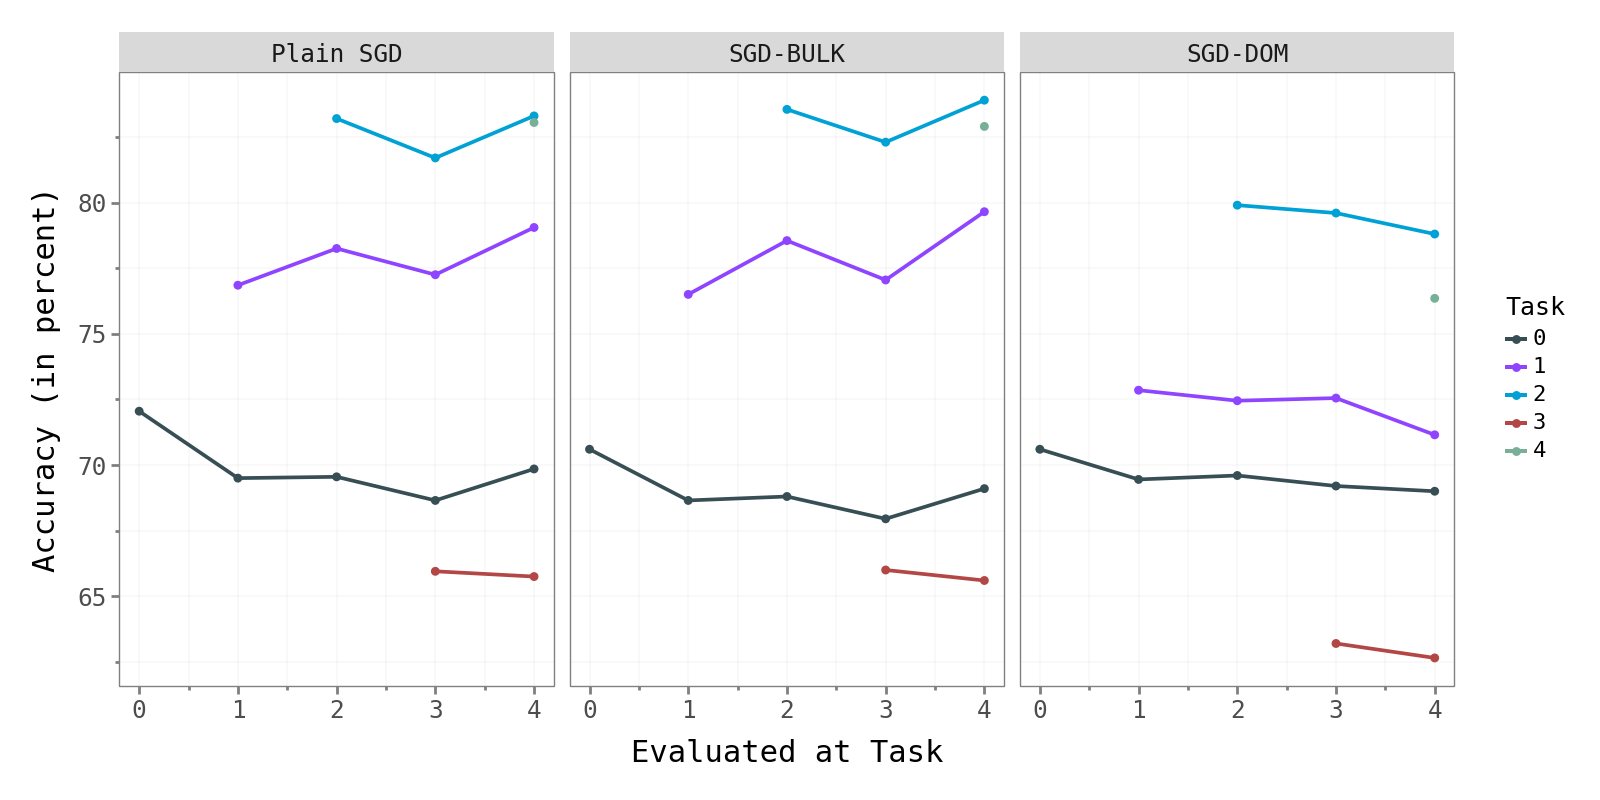

In [16]:
plot_test_metric(pd.concat([cifar10_main_dict[space]['test_metrics'] for space in SUBSPACE_TYPES]))

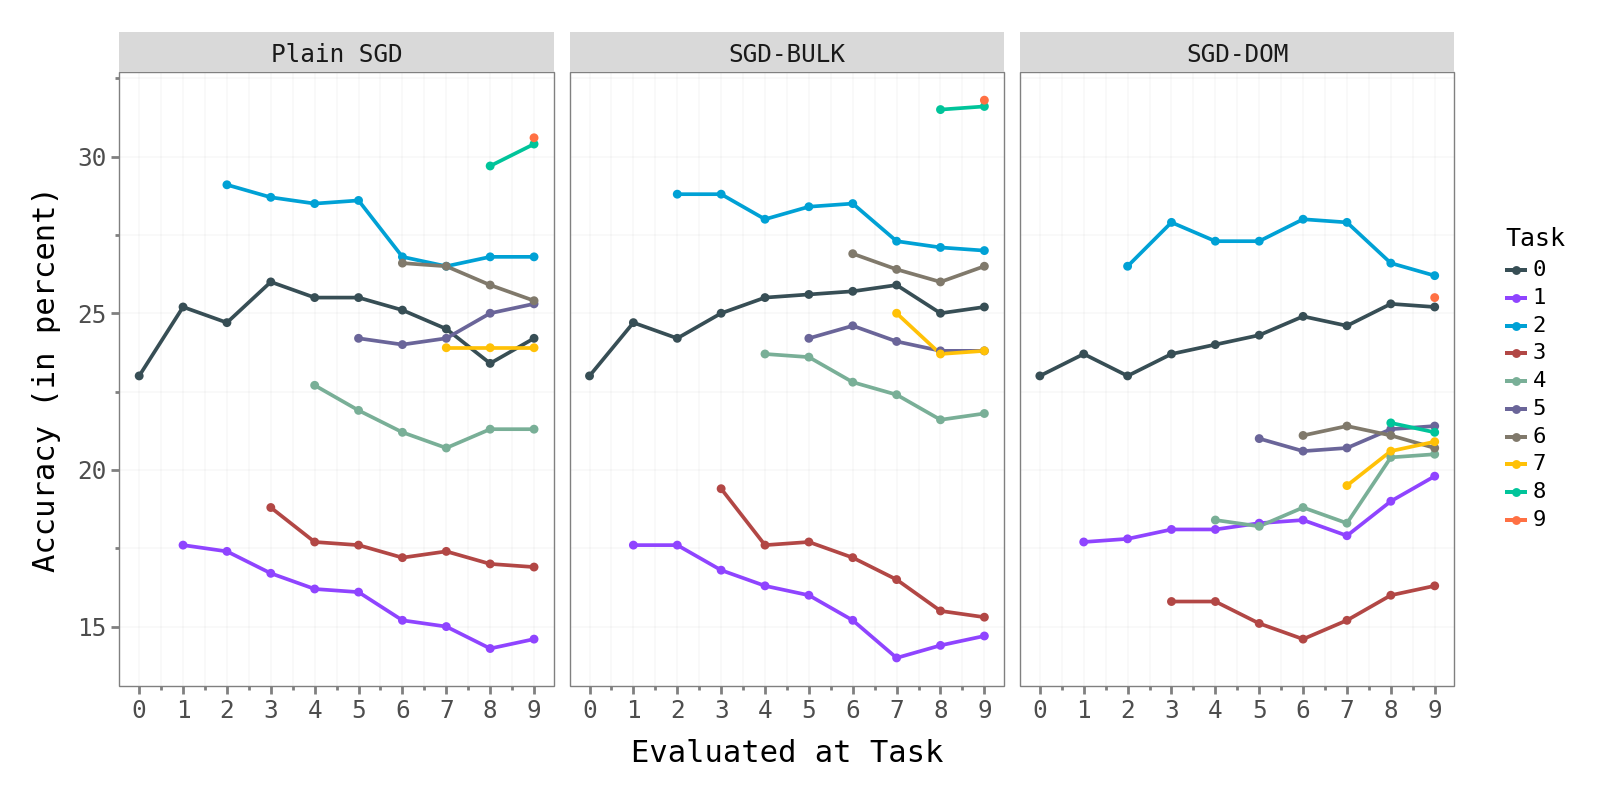

In [17]:
plot_test_metric(pd.concat([cifar100_main_dict[space]['test_metrics'] for space in SUBSPACE_TYPES]))

### Eigenvalues over Time for SGD-BULK (Ablation)

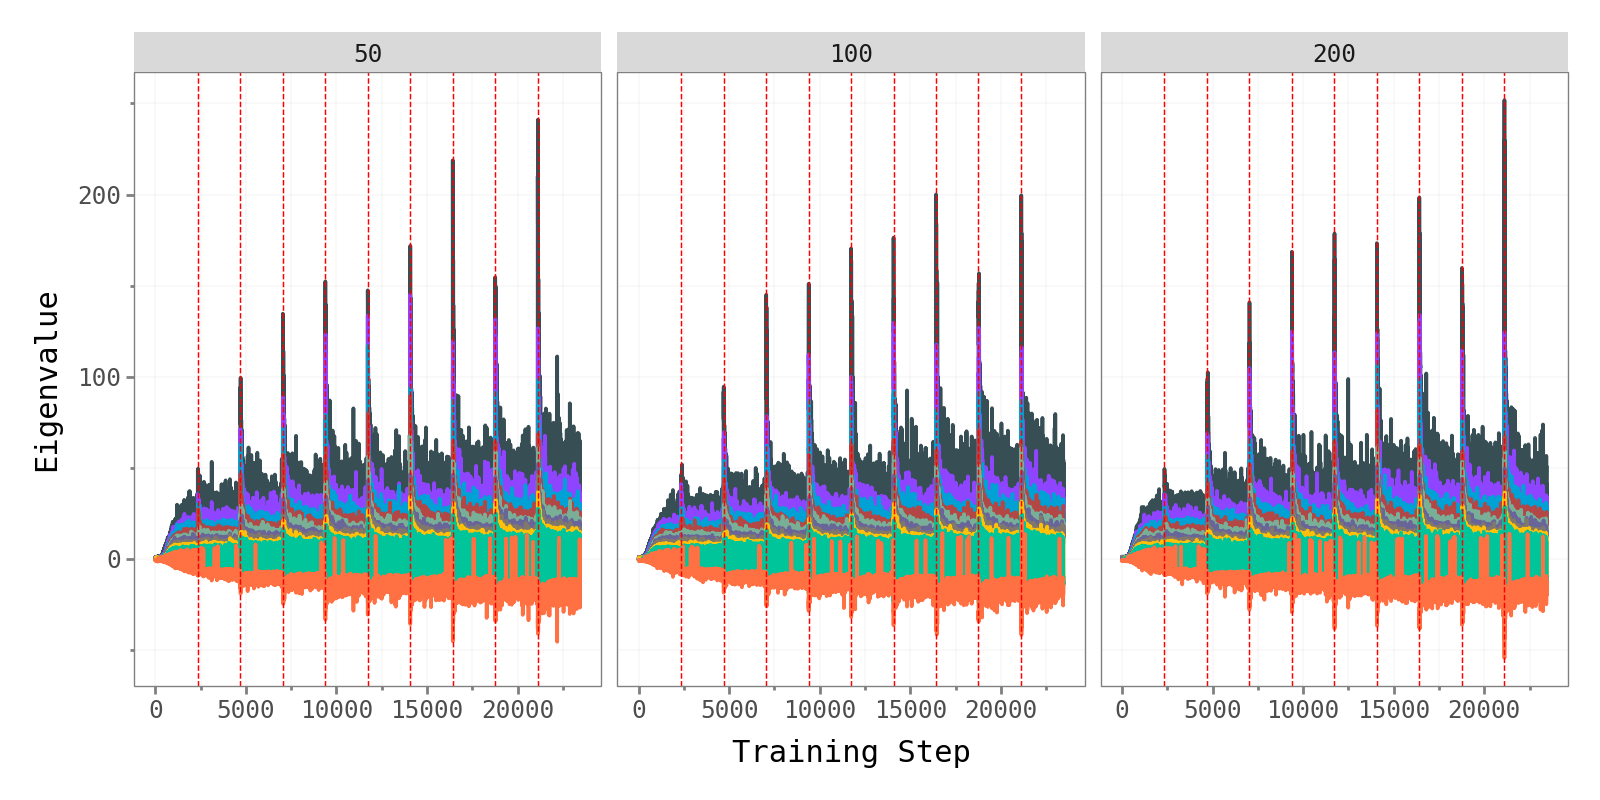

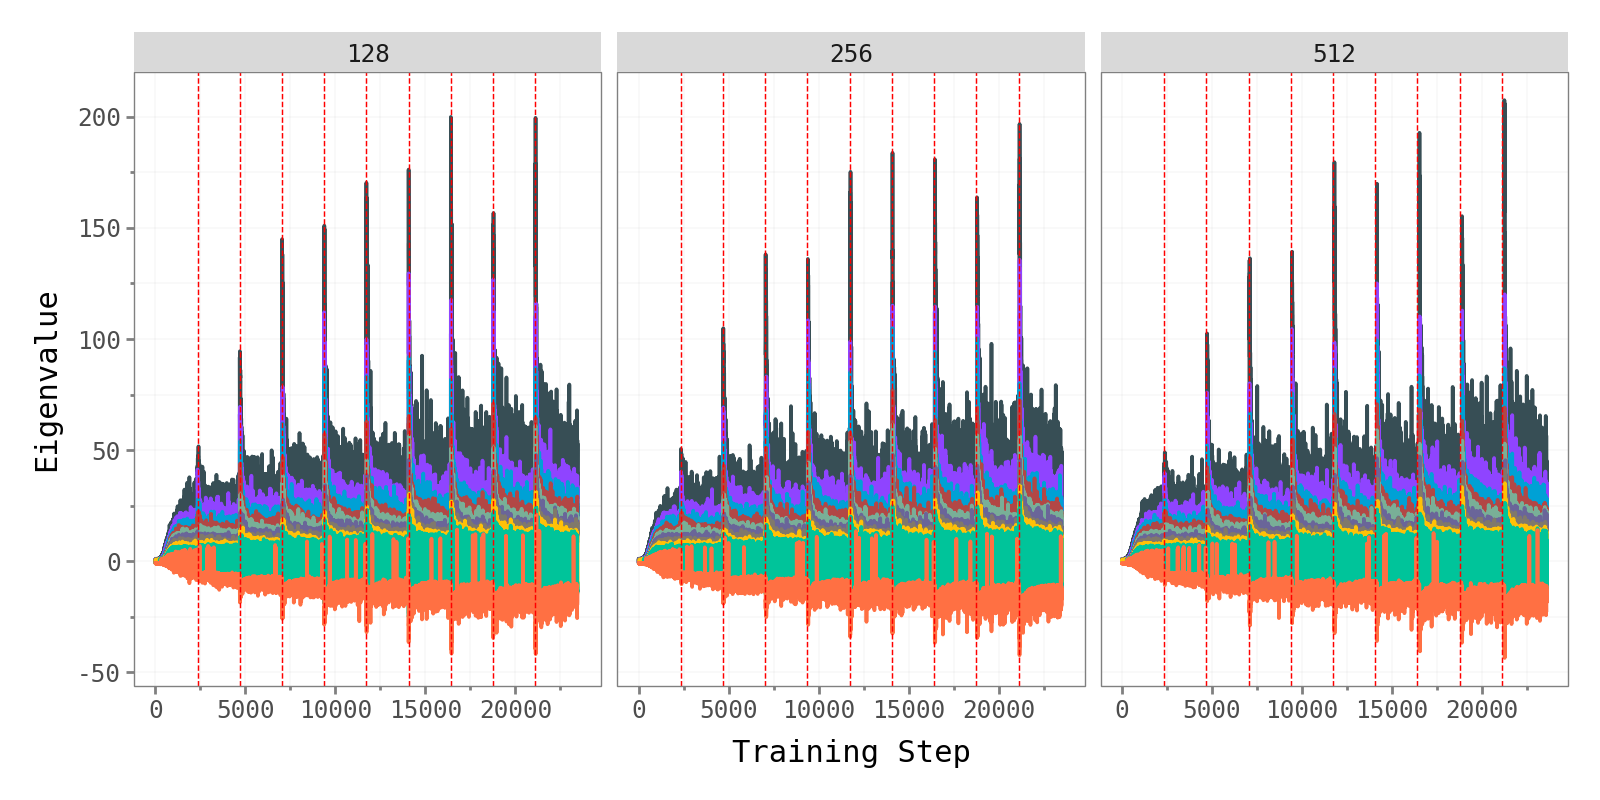

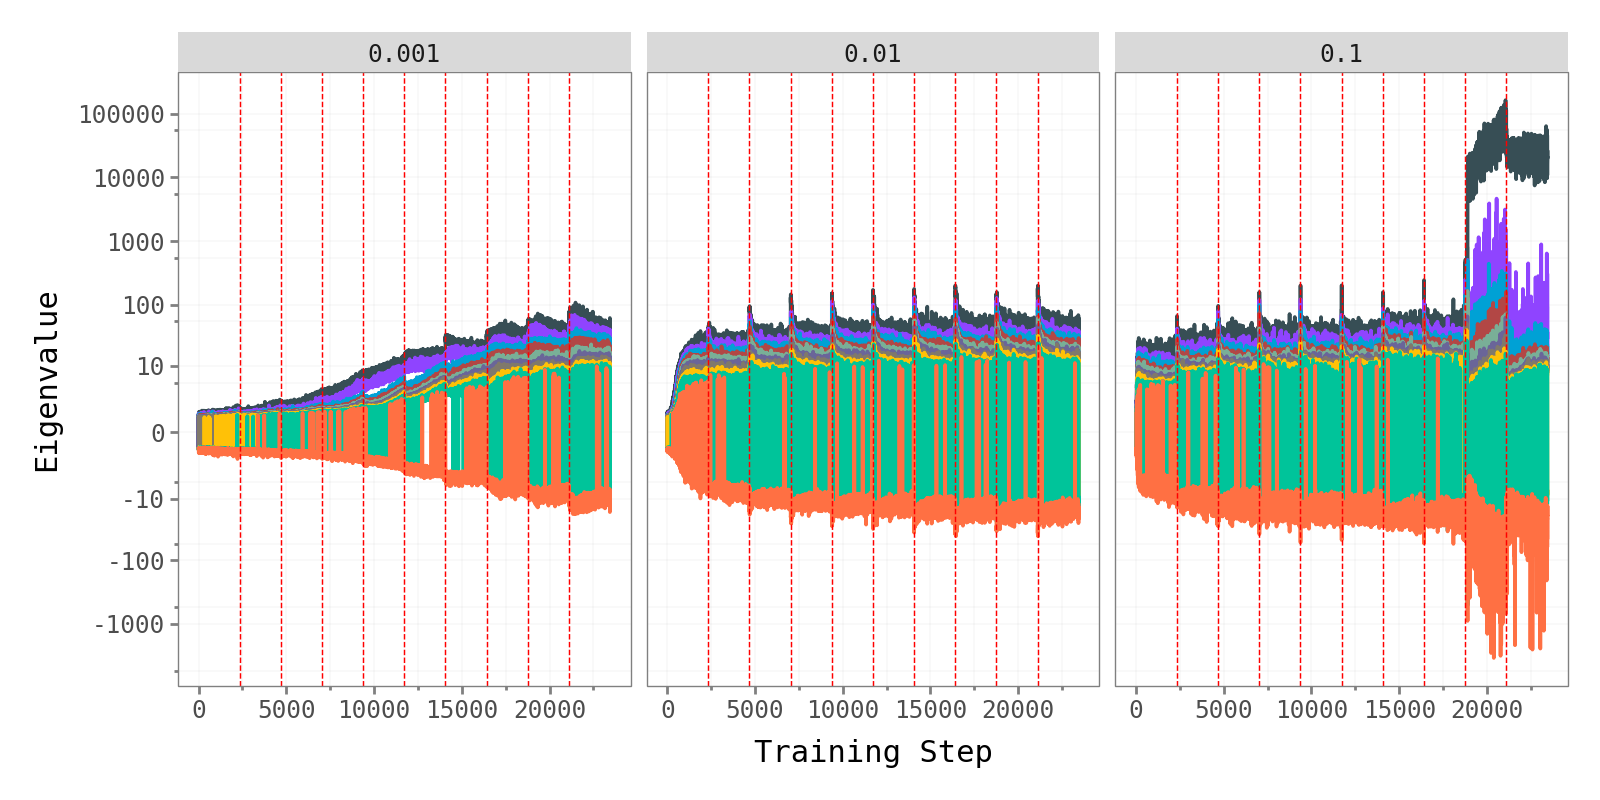

In [18]:
eigenvalues_ablation(pmnist_main_dict['bulk']['eigenvalues'], pmnist_ablation_dict, PMNIST_BOUNDARIES)

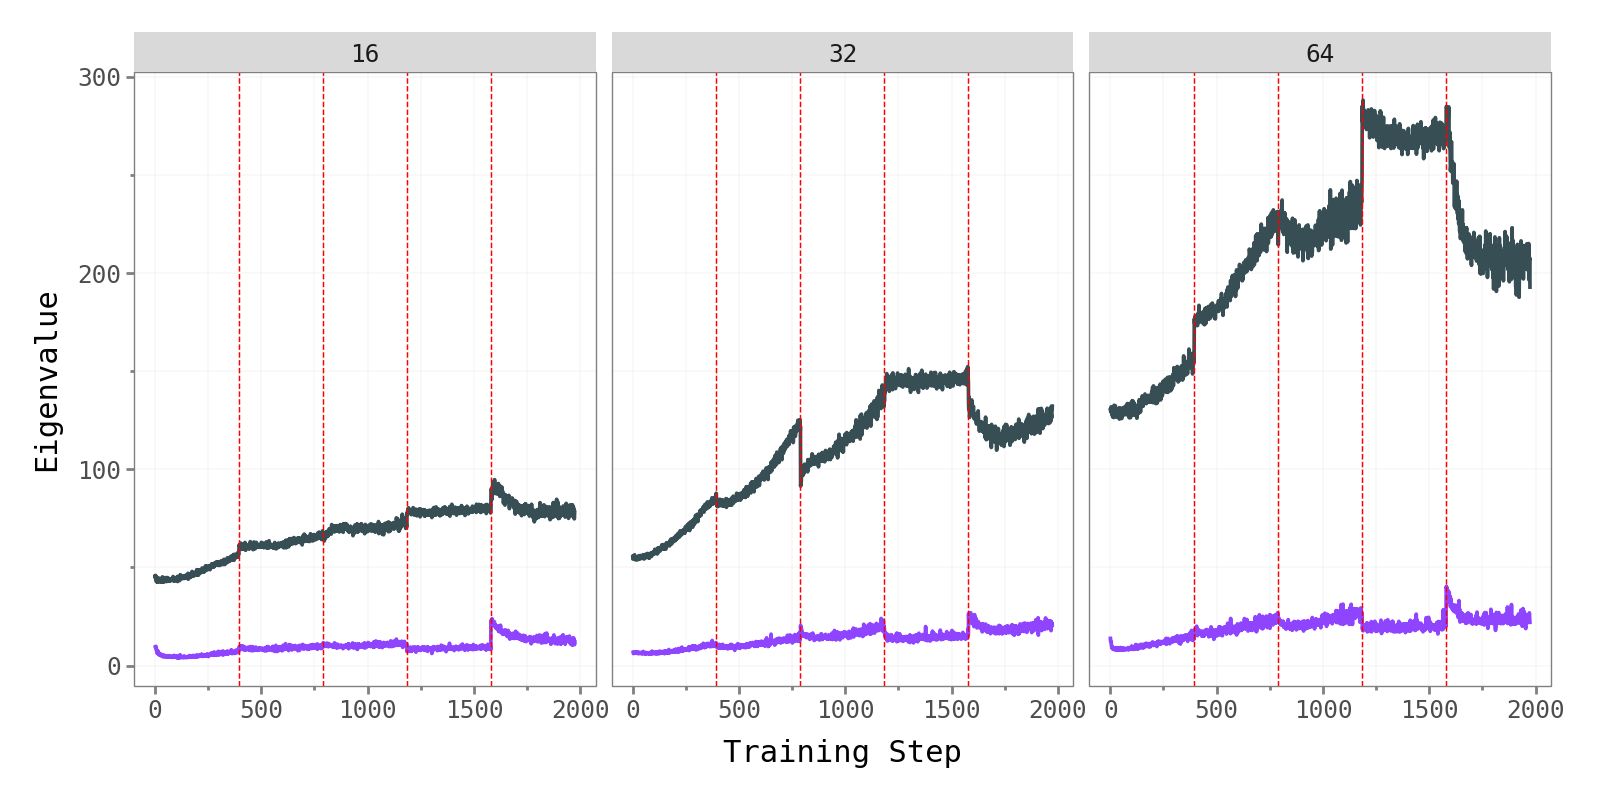

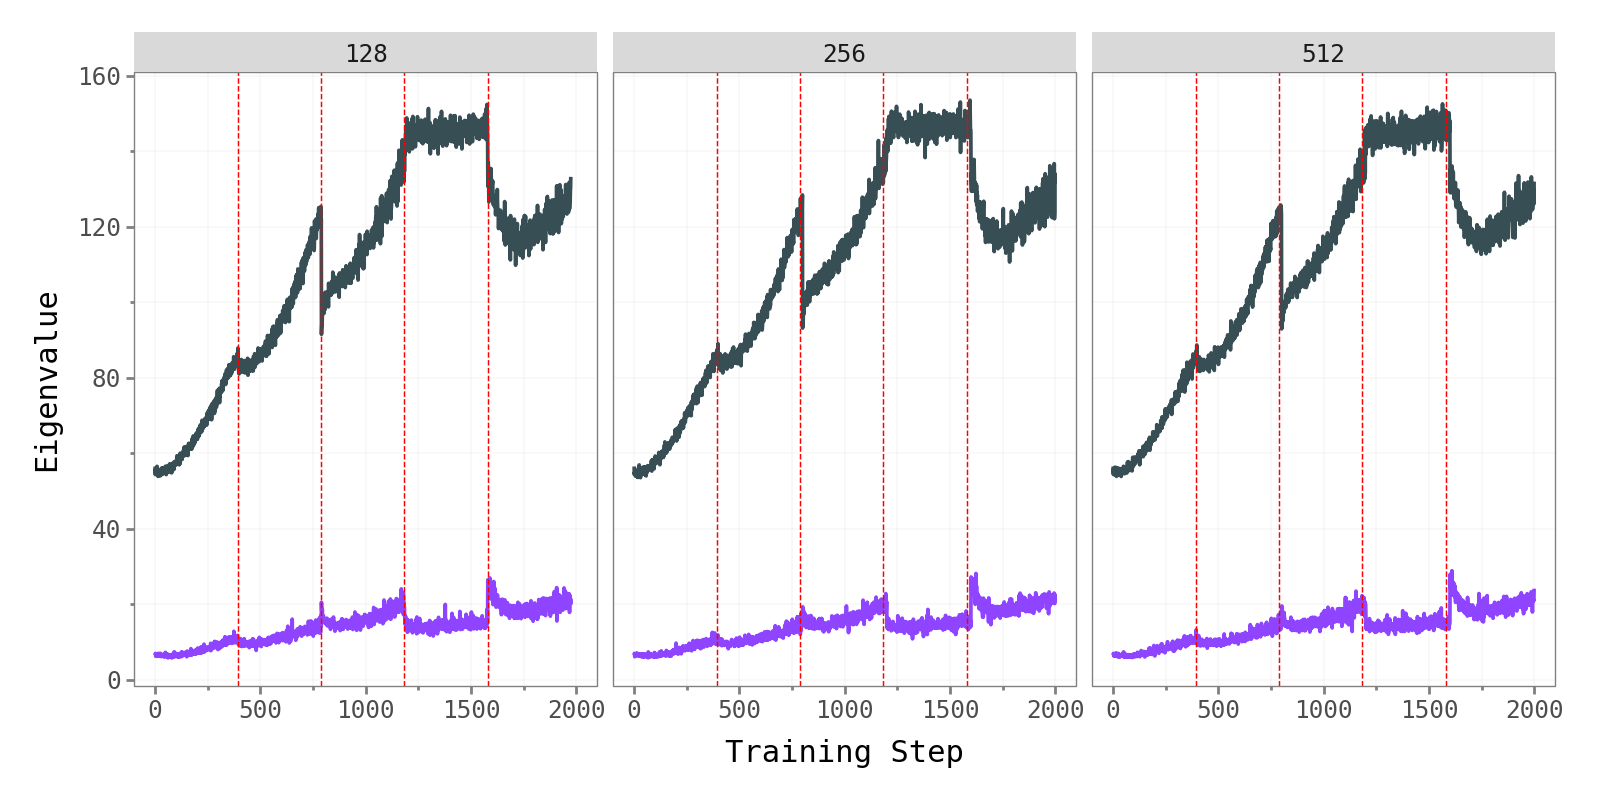

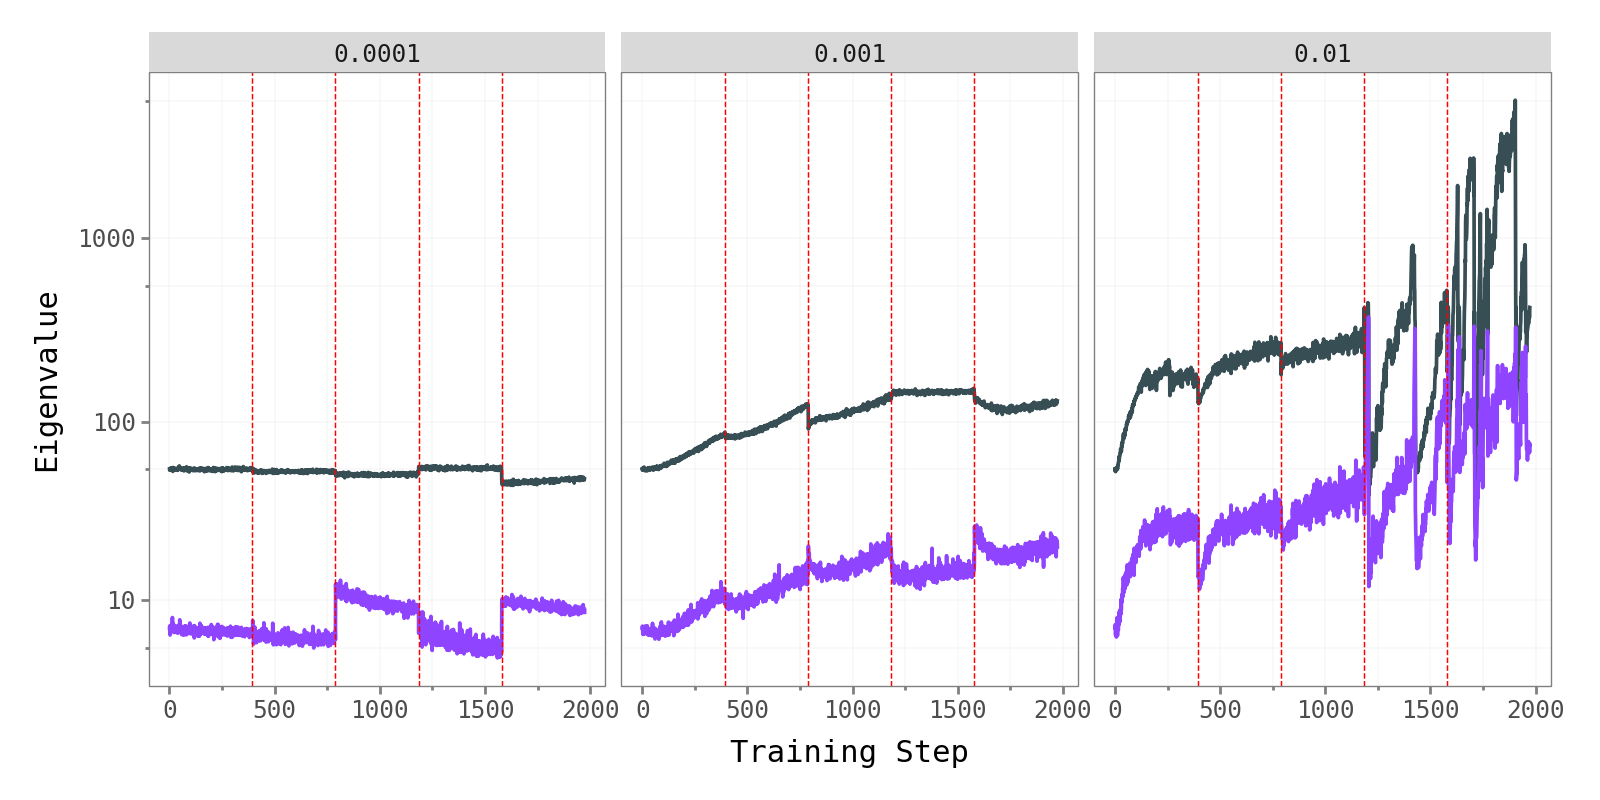

In [19]:
eigenvalues_ablation(cifar10_main_dict['bulk']['eigenvalues'], cifar10_ablation_dict, CIFAR10_BOUNDARIES)

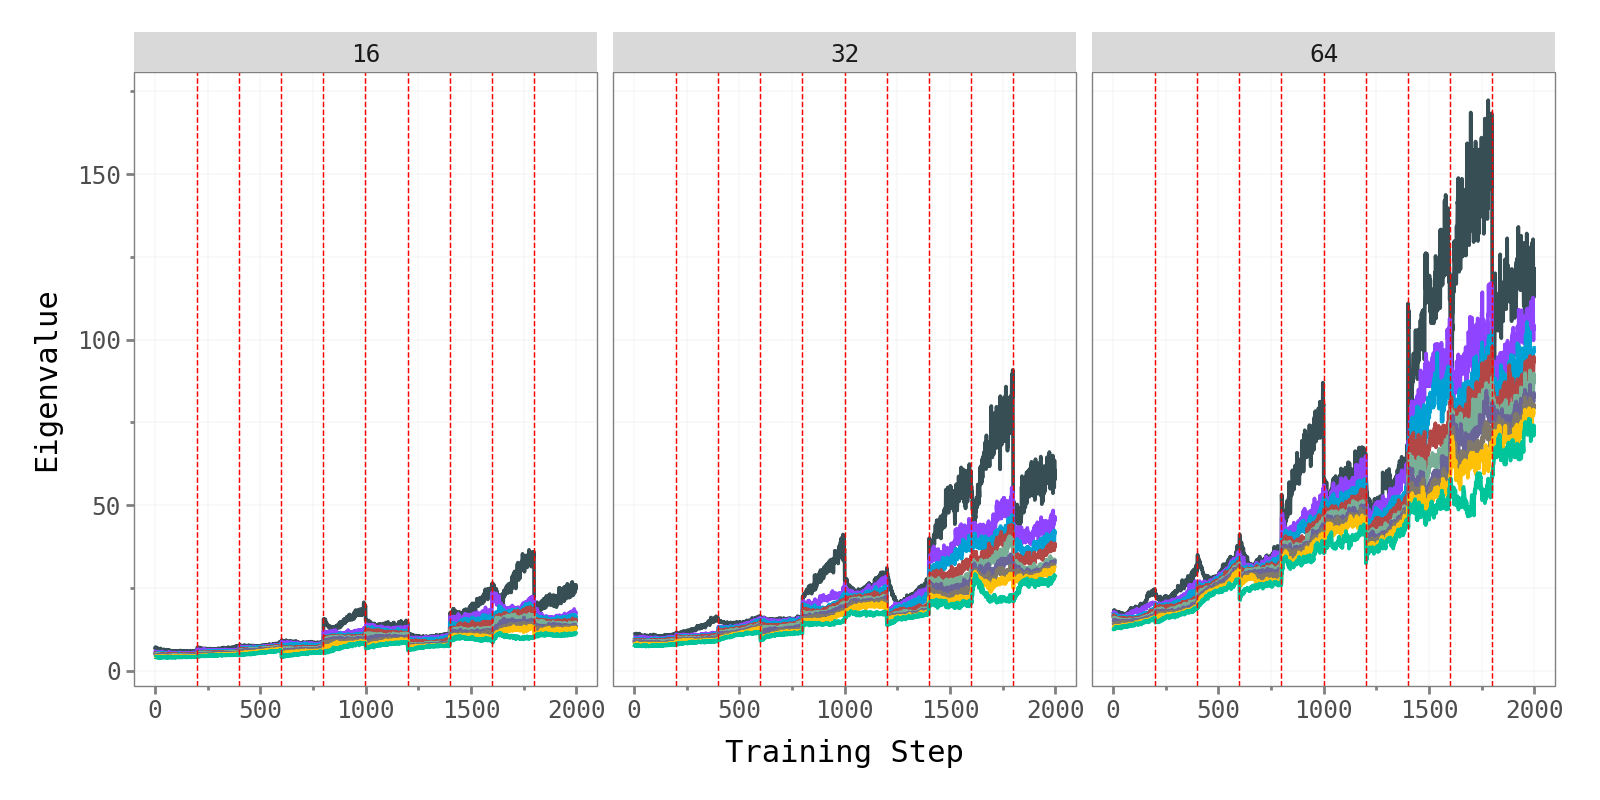

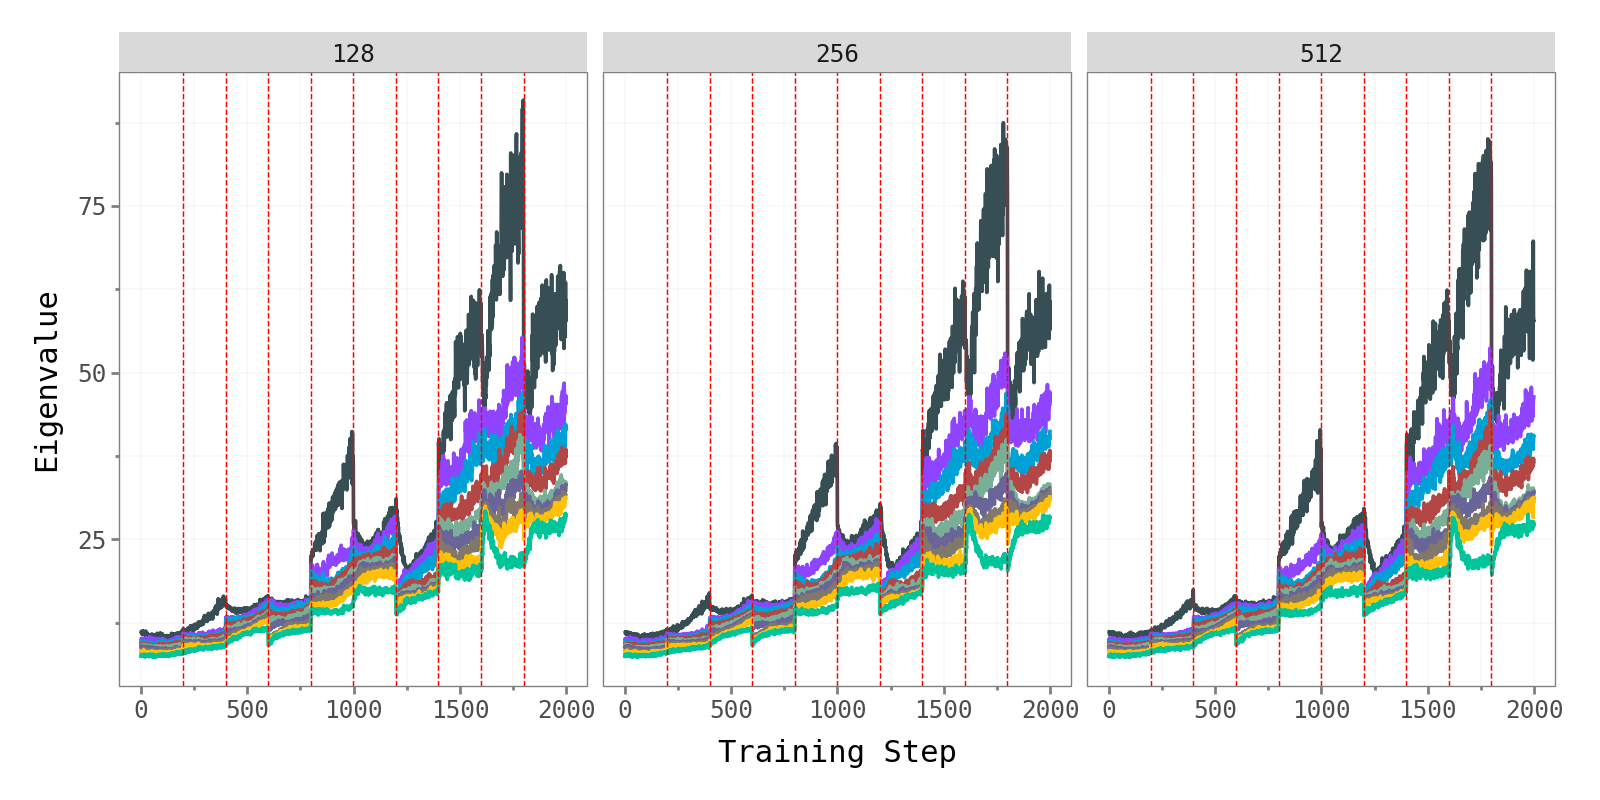

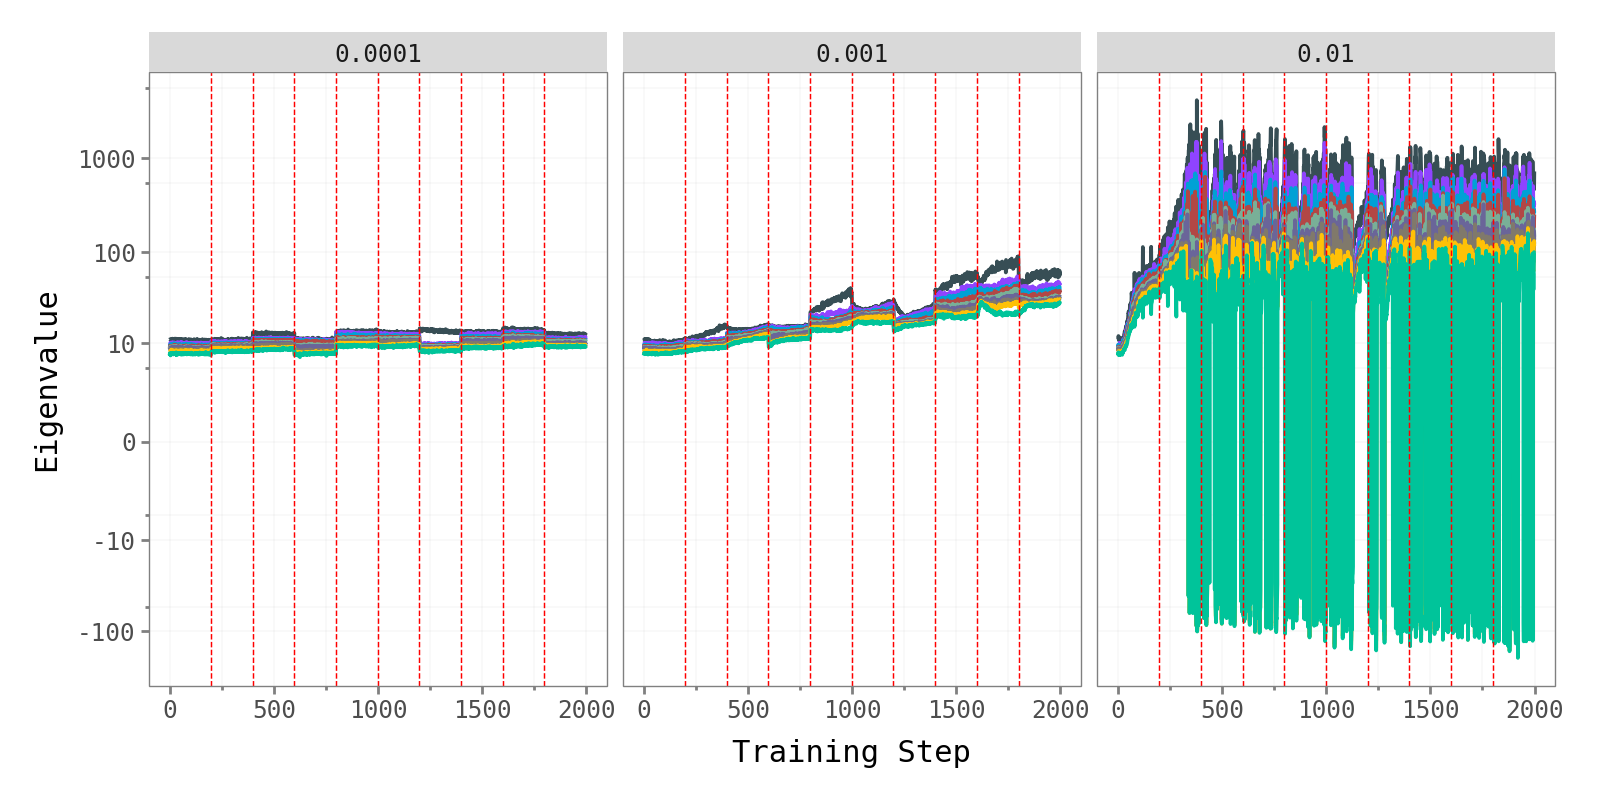

In [20]:
eigenvalues_ablation(cifar100_main_dict['bulk']['eigenvalues'], cifar100_ablation_dict, CIFAR100_BOUNDARIES)

### Appendix: Overlap over Time (Ablation)

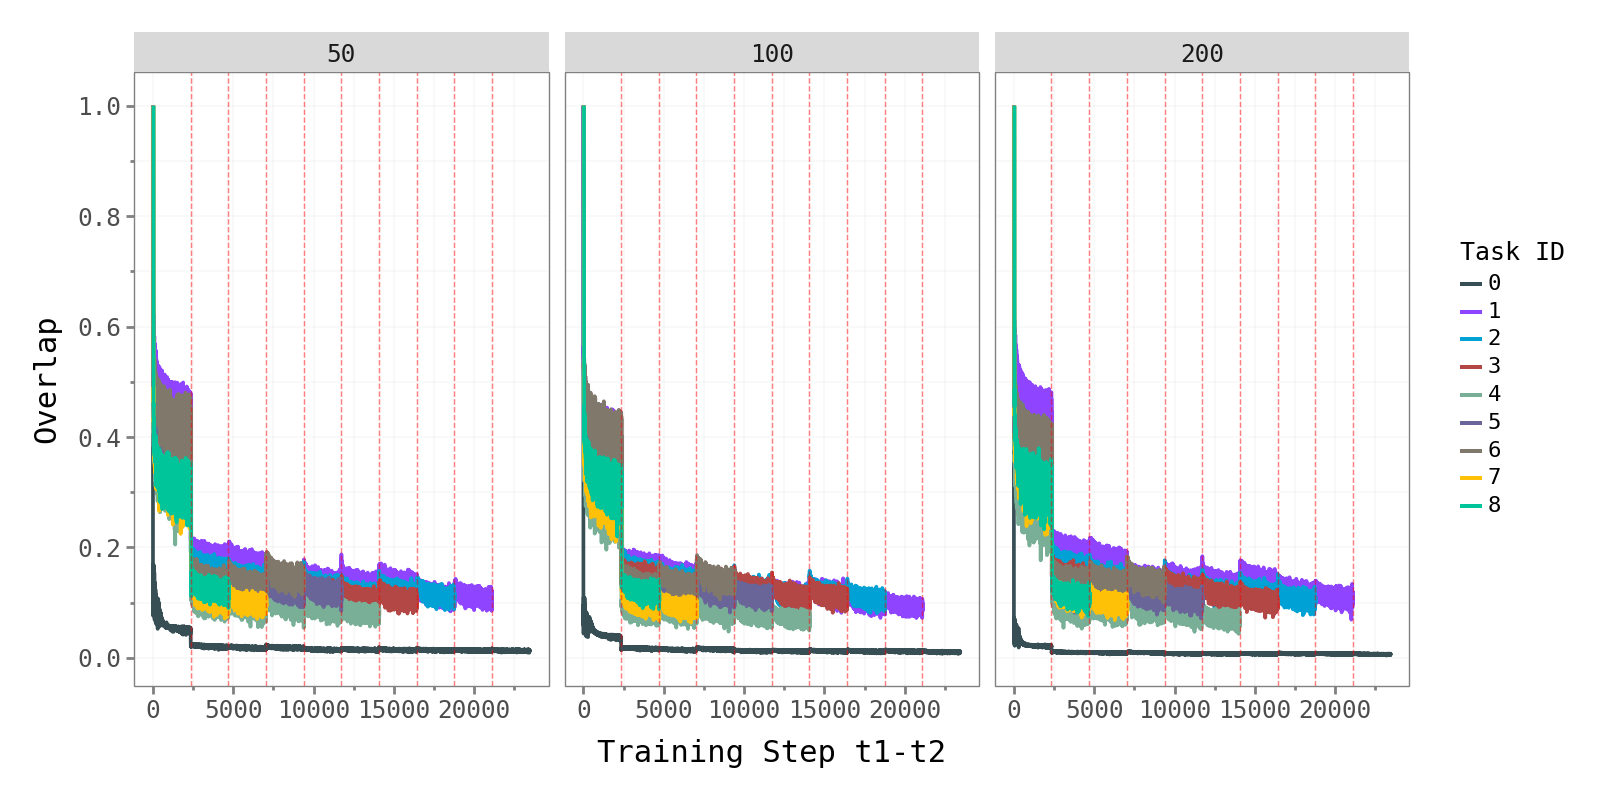

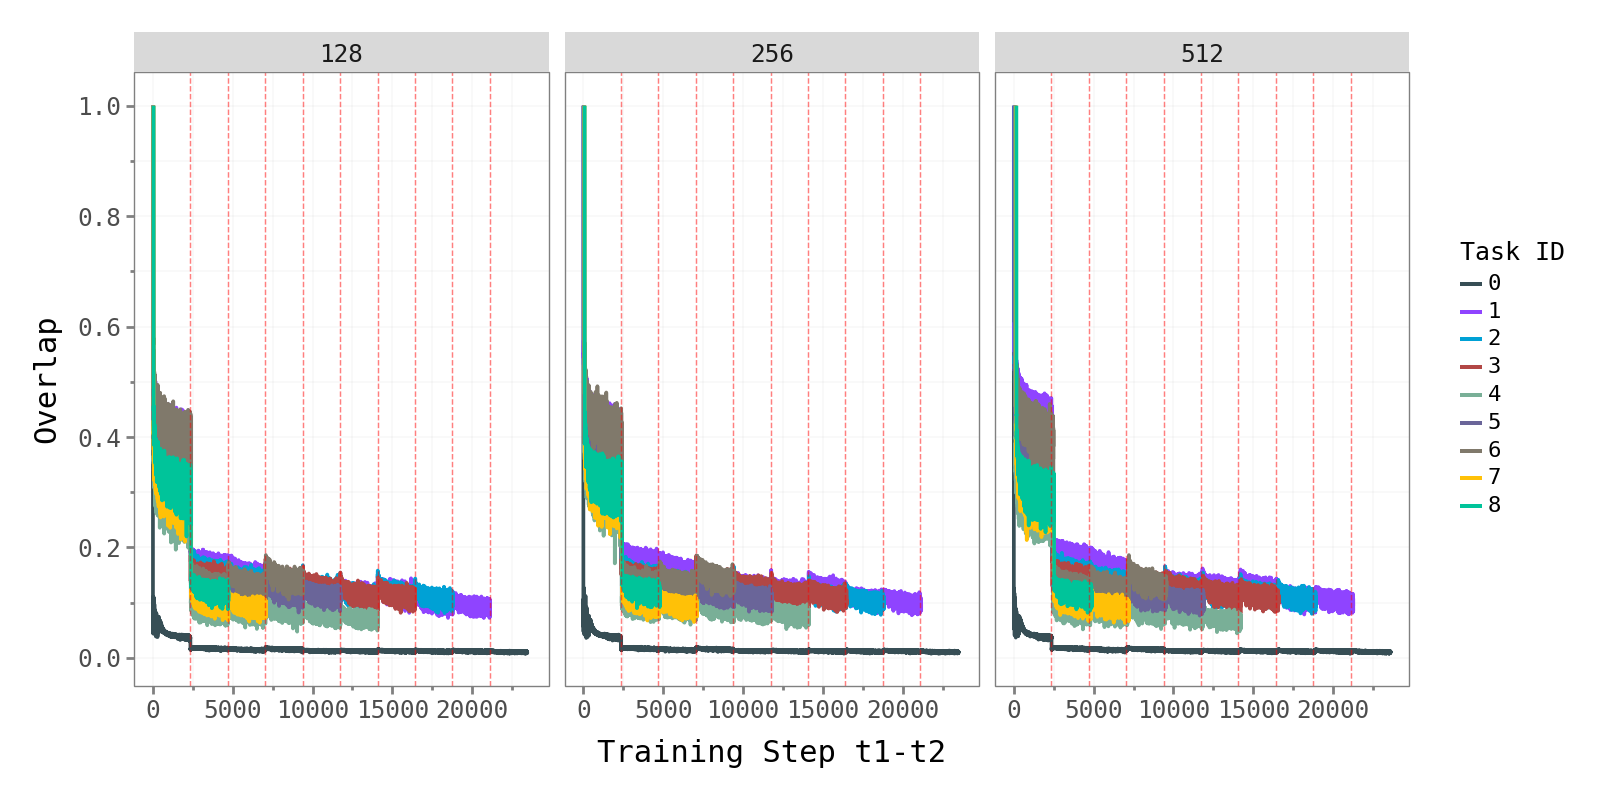

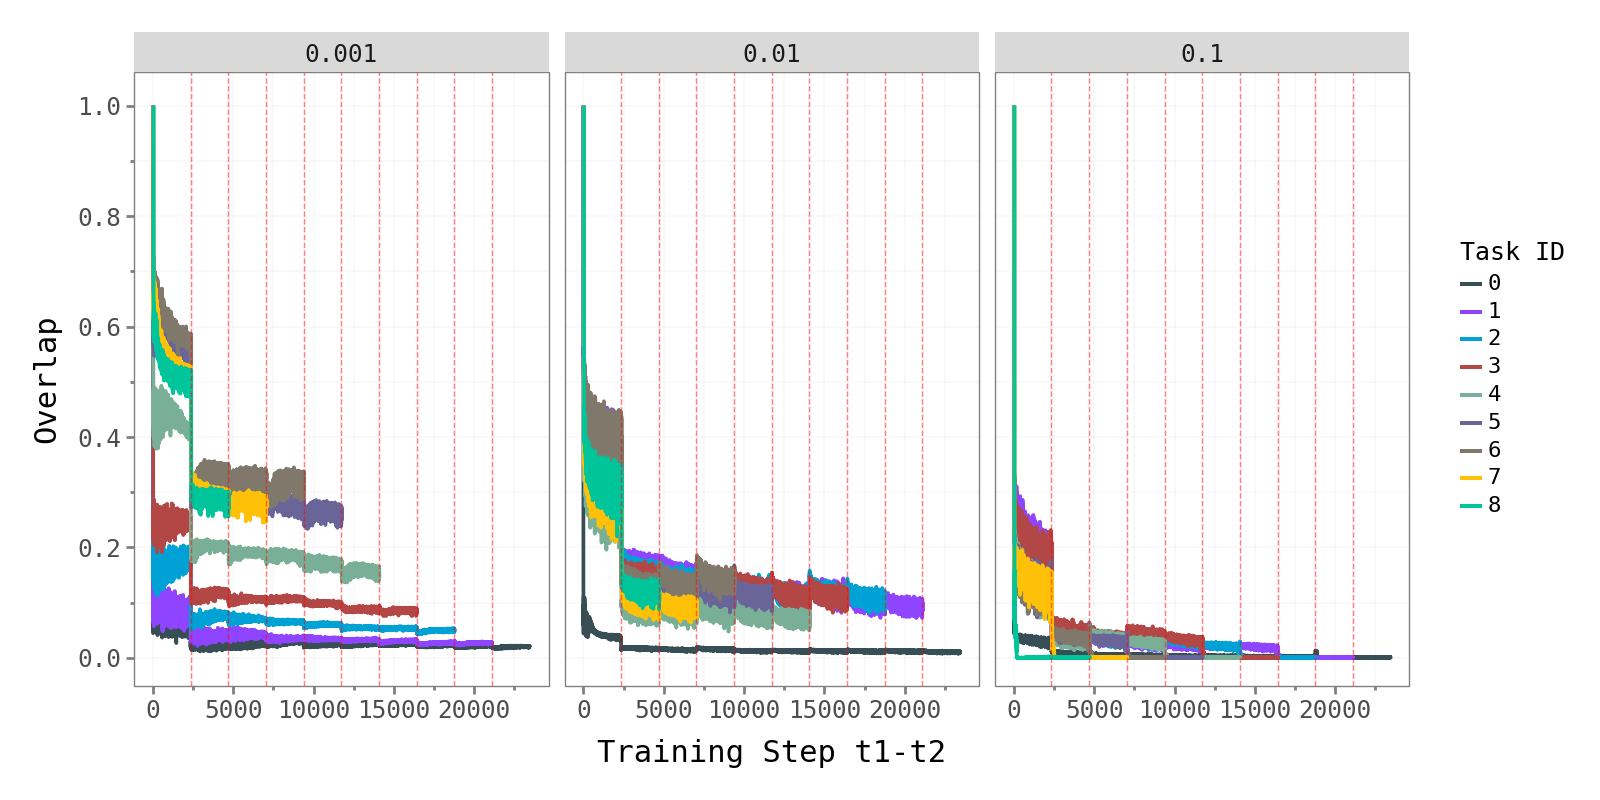

In [21]:
overlap_ablation(pmnist_main_dict['bulk']['overlaps'], pmnist_ablation_dict, PMNIST_BOUNDARIES)

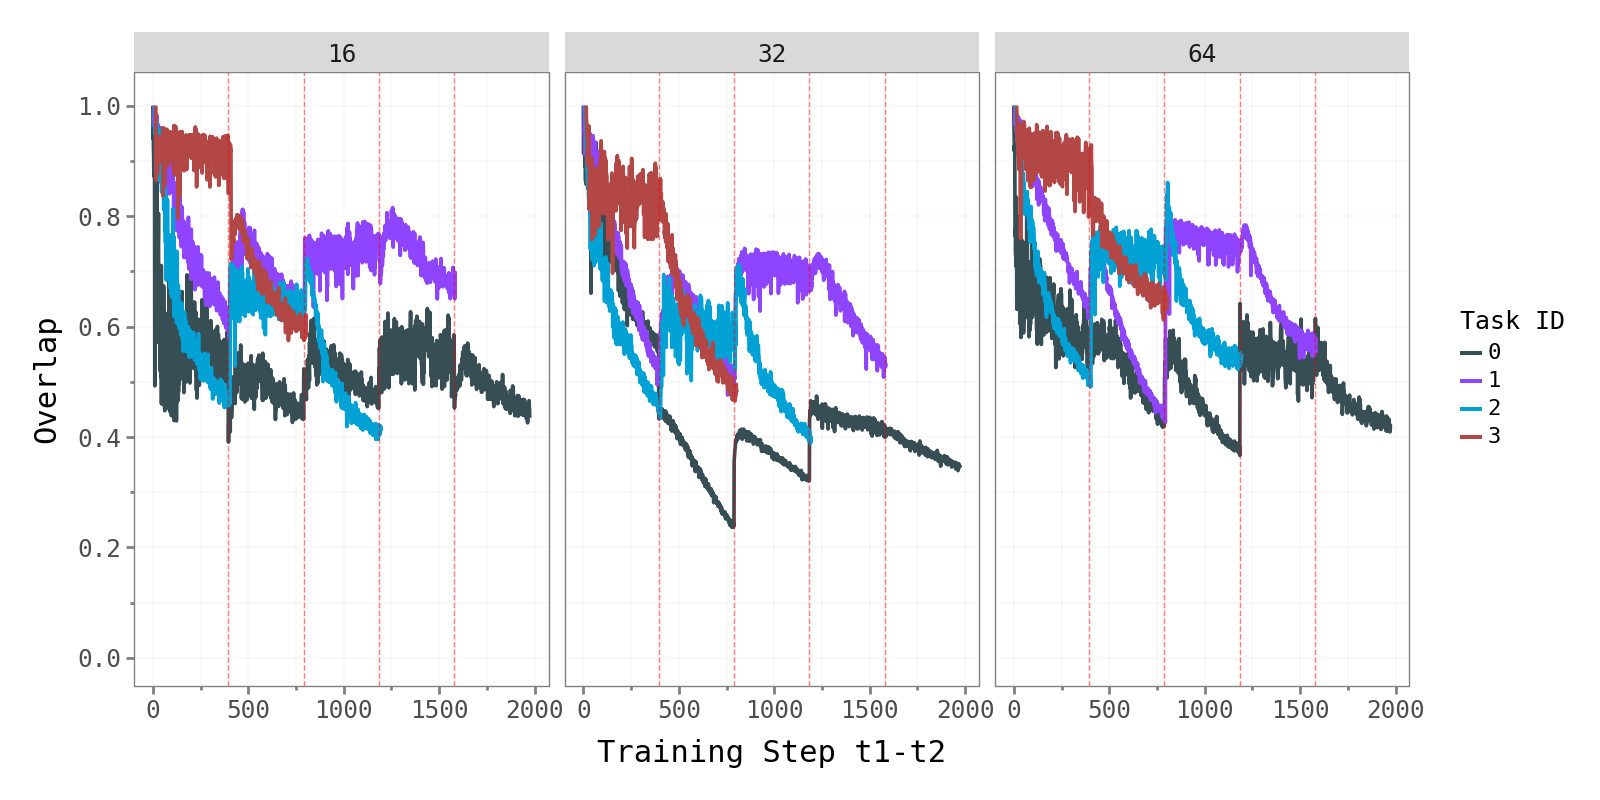

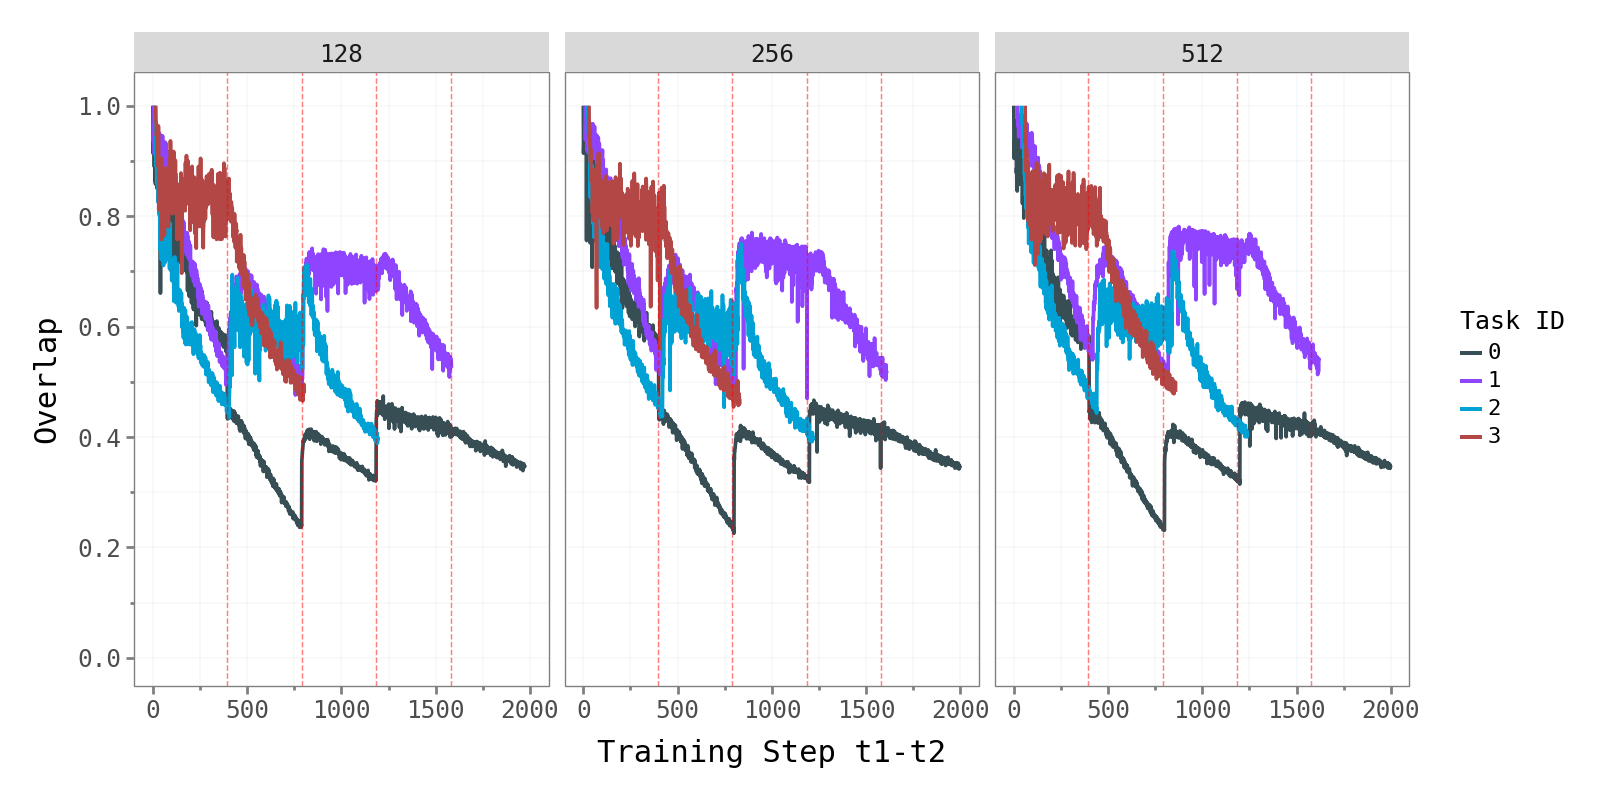

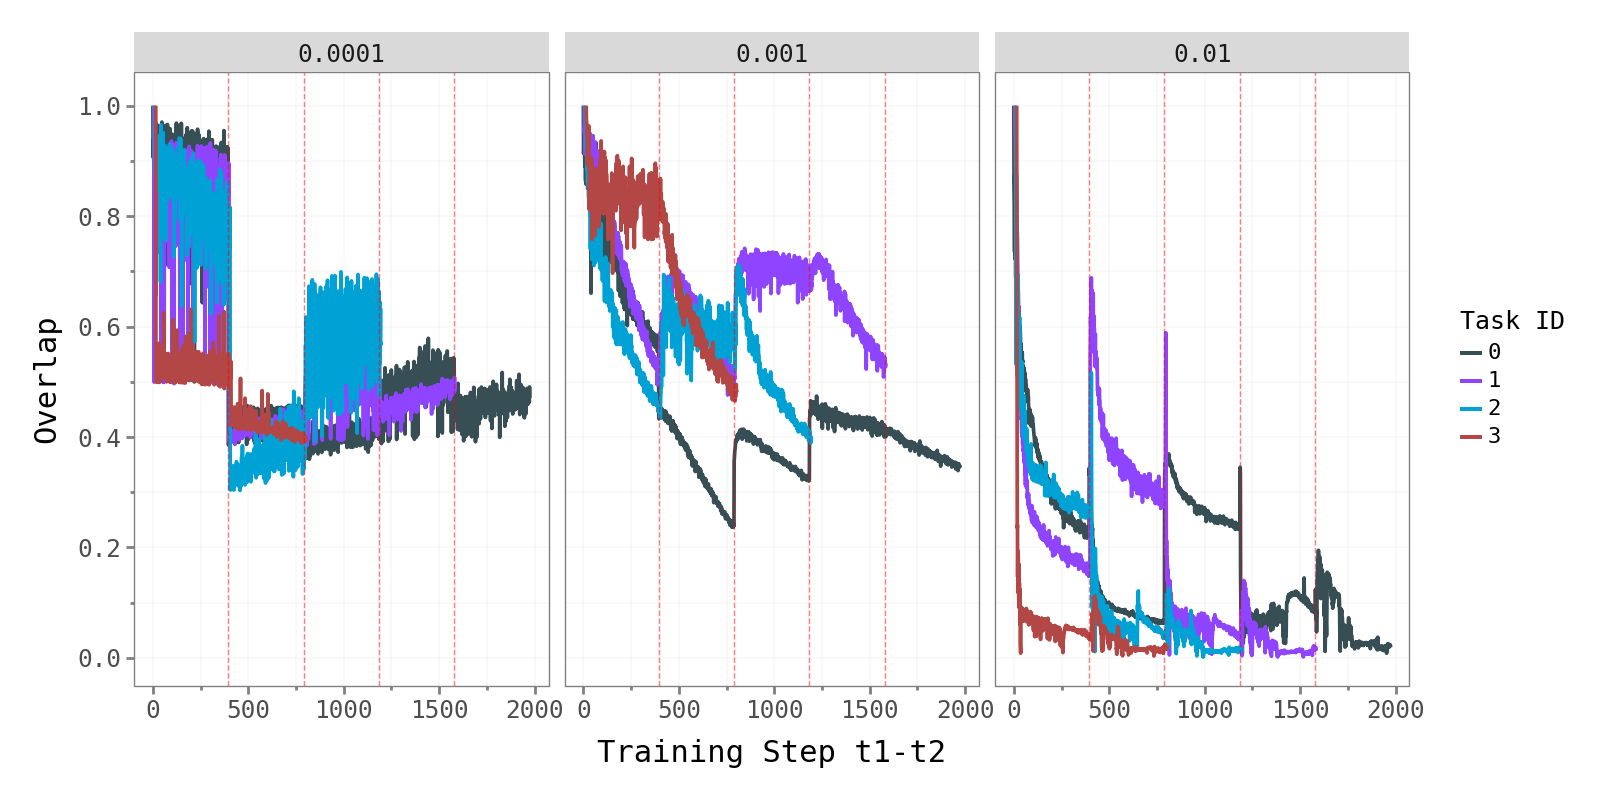

In [22]:
overlap_ablation(cifar10_main_dict['bulk']['overlaps'], cifar10_ablation_dict, CIFAR10_BOUNDARIES)

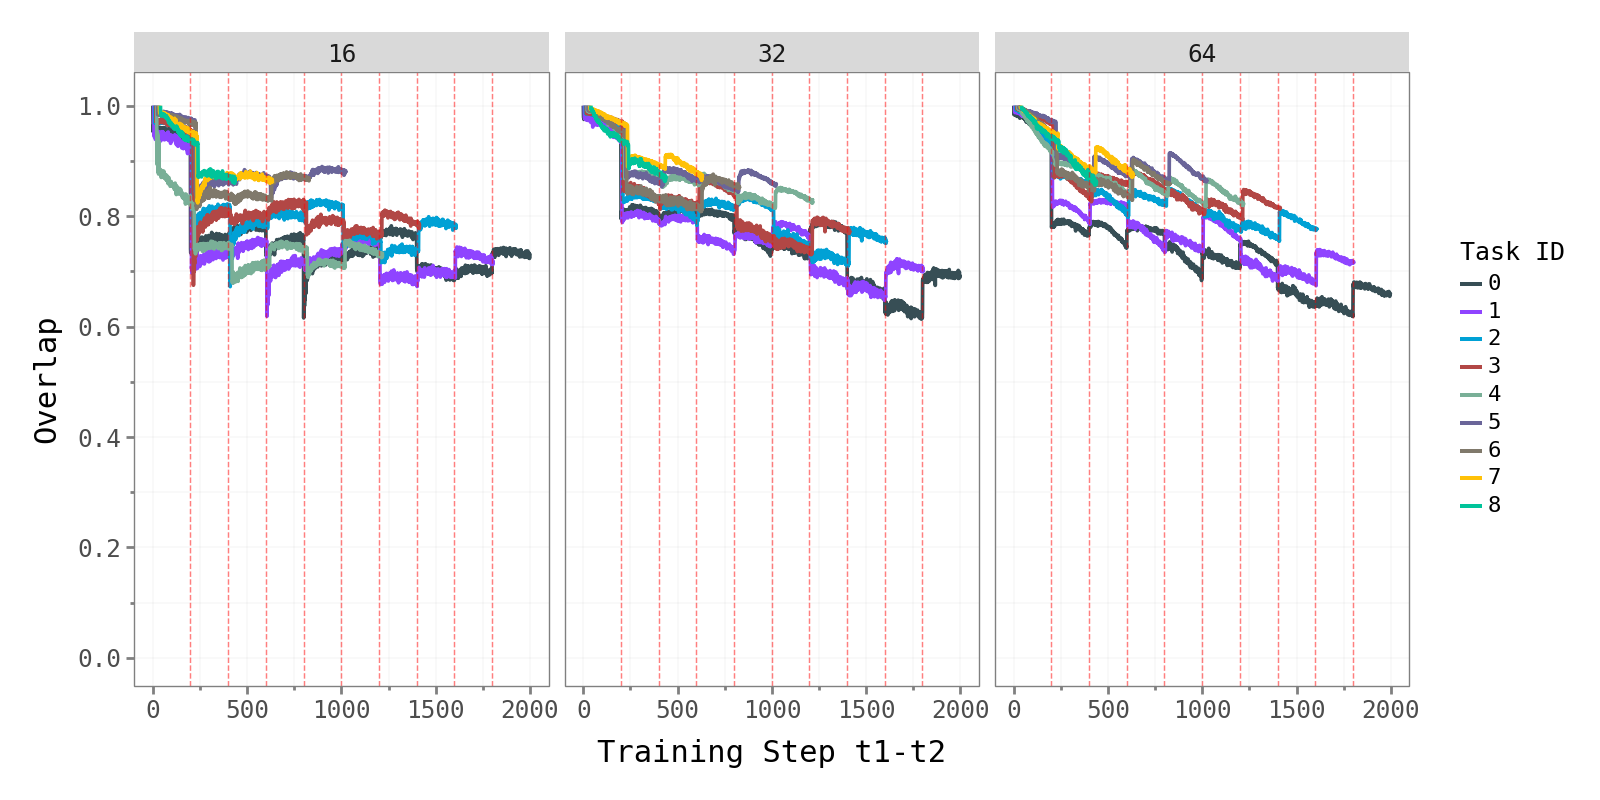

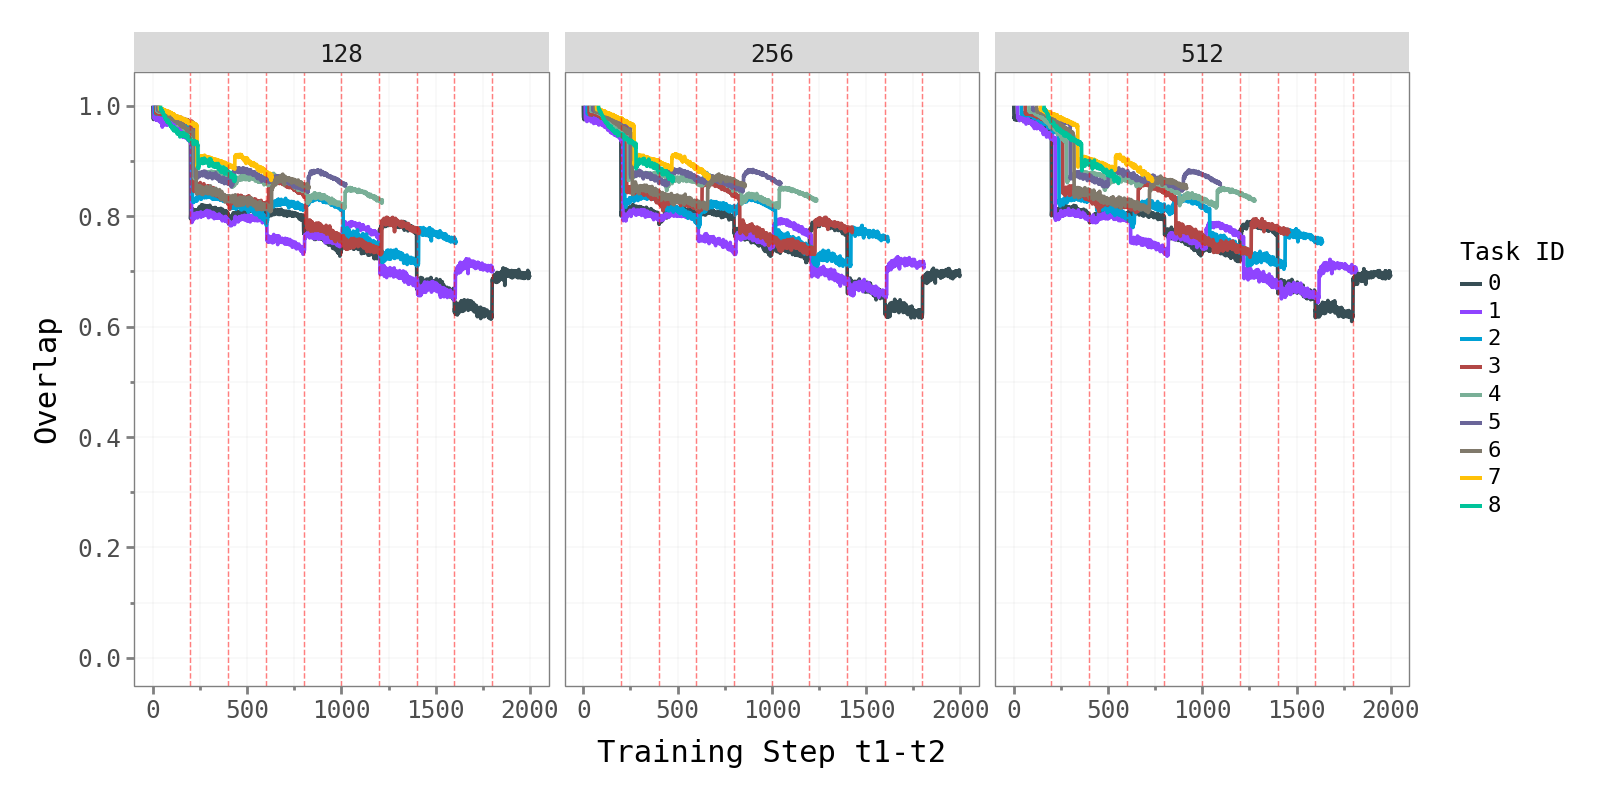

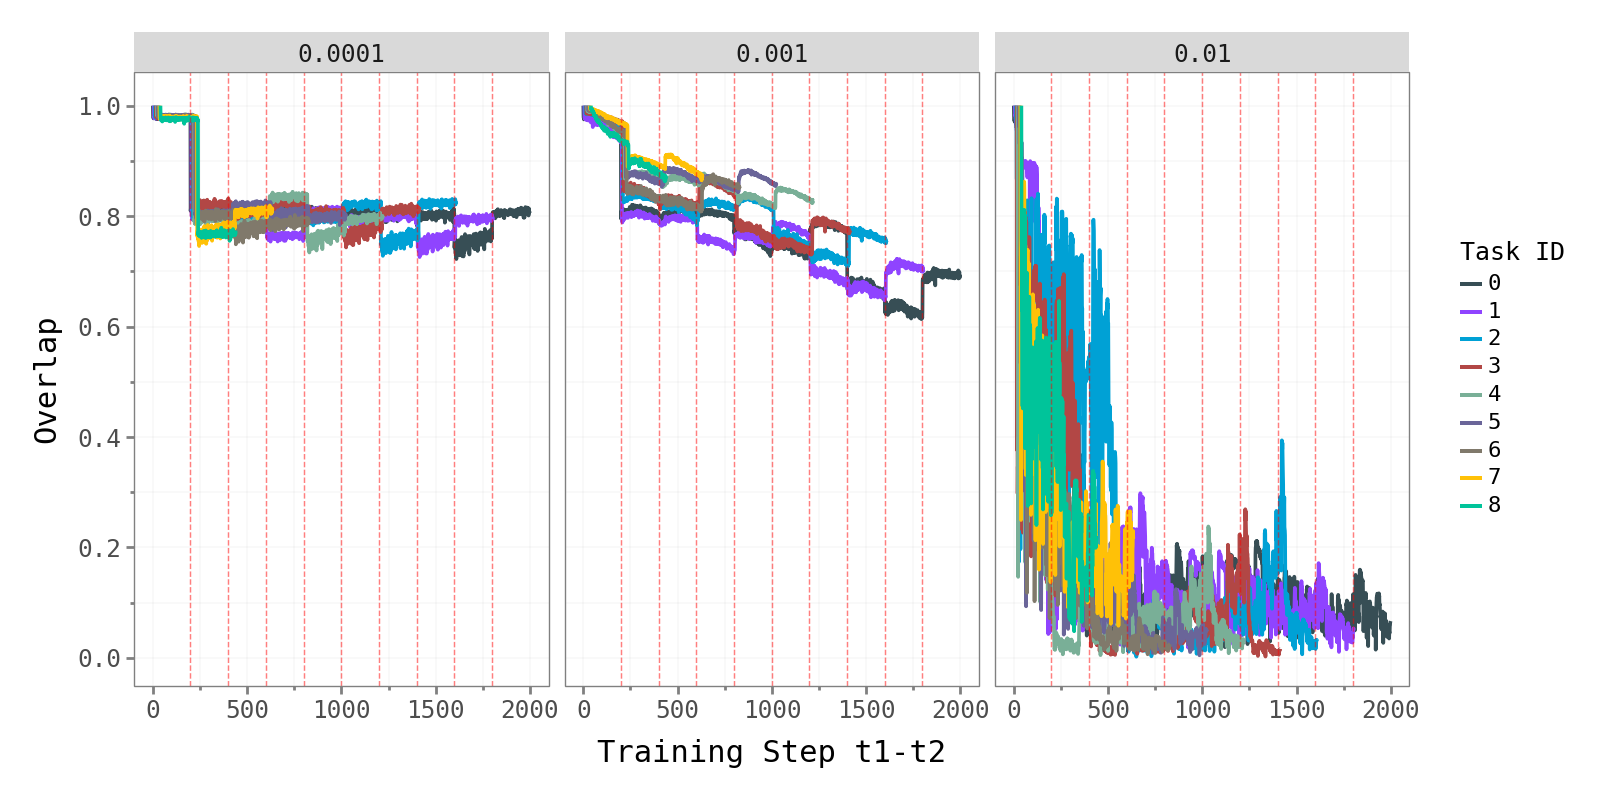

In [23]:
overlap_ablation(cifar100_main_dict['bulk']['overlaps'], cifar100_ablation_dict, CIFAR100_BOUNDARIES)